# Final Project:

**Course:** CSCI-B-M213 - Embedded Systems  
**Project Title:** Nonlinear Optimal Control for UAVs with Tilting Rotors

**Team Members:**
- BADDOU Mounia
- IMRHARN Imane
- KABLY Malak
- LABZAE Kawtar
- MEJHOUDI Khaoula


**Reference Papers:**  
This notebook implements the control strategies described in:
*"Nonlinear optimal control for UAVs with tilting rotors"*

Throughout this Jupyter notebook, various equations and methods reference sections from this paper (e.g., Equations 43-53 for Jacobian computation, Equations 60-61 for H∞ controller design, Equations 75-76 for Kalman filter implementation).

The implementation also extends beyond the reference paper by including additional features and implementations such as obstacle avoidance algorithms, waypoint navigation systems, and enhanced visualization tools for comprehensive mission analysis.

## 1) Setup & Numerical Tools

This section imports the necessary Python libraries for implementing and simulating the **H∞ robust control** system for a **tilt-rotor UAV**.

### Required Libraries:

- **NumPy**: For efficient numerical linear algebra operations (matrix multiplication, eigenvalue computation, solving linear systems)
- **Matplotlib**: For visualization of simulation results (3D trajectories, state responses, control inputs)
- **SciPy**: For solving the **Algebraic Riccati Equation (ARE)** which is central to both H∞ and LQR controller design:
  $$A^TP + PA - PBR^{-1}B^TP + Q = 0$$

### Mathematical Foundation:

The implementation relies heavily on:
1. **Linear algebra** operations for computing Jacobians, matrix exponentials, and solving control Riccati equations
2. **Numerical integration** using Runge-Kutta methods (via `scipy.integrate.solve_ivp`)
3. **Optimization** algorithms for Riccati equation solutions

These tools enable us to implement the complete control pipeline: **dynamics modeling → linearization → H∞ synthesis → closed-loop simulation → performance analysis**.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_continuous_are
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

## 2) System Parameters & Physical Model

The **tilt-rotor UAV** is characterized by its **mass**, **inertia tensor**, and **rotor properties**. These parameters define the physical dynamics of the vehicle.

### Physical Parameters:

#### **Mass and Inertia:**
- **m**: Total mass of the UAV (kg)
- **Inertia Matrix** $\mathbf{J}$: Describes the UAV's resistance to rotational acceleration in the body frame:
  $$\mathbf{J} = \begin{bmatrix} I_{xx} & 0 & 0 \\ 0 & I_{yy} & 0 \\ 0 & 0 & I_{zz} \end{bmatrix}$$
  - $I_{xx}$: Moment of inertia about the body x-axis (roll)
  - $I_{yy}$: Moment of inertia about the body y-axis (pitch)
  - $I_{zz}$: Moment of inertia about the body z-axis (yaw)

#### **Rotor Characteristics:**
- **kf**: Thrust coefficient (N/unit²) - relates rotor angular velocity to thrust force
- **km**: Moment coefficient (N·m/unit²) - relates rotor angular velocity to torque
- **l**: Arm length (m) - distance from center of mass to rotor
- **alpha**: Tilt angle of rotors (rad) - defines the tilting capability that gives this UAV enhanced maneuverability

#### **Gravitational Acceleration:**
- **g**: 9.81 m/s² - standard gravity

### Coordinate Frames:

- **Inertial Frame** {I}: Fixed earth frame (North-East-Down or similar)
- **Body Frame** {B}: Attached to UAV, rotates with the vehicle

The **rotation matrix** $\mathbf{R}(\phi, \theta, \psi)$ transforms vectors from body frame to inertial frame using the **ZYX Euler angle** convention (yaw-pitch-roll).

These parameters come from the physical design and are used in the nonlinear dynamics equations.

In [ ]:
# SYSTEM PARAMETERS

class TiltRotorUAVParameters:
    """Physical parameters for a quadrotor UAV with tilting rotors"""
    def __init__(self):
        self.m = 2.0
        self.g = 9.81
        
        self.Ix = 0.0347563
        self.Iy = 0.0458929
        self.Iz = 0.0977
        
        self.kf = 1.0e-5
        self.km = 1.0e-7
        self.l = 0.25
        
        # Increased damping for stability
        self.C1 = 0.1
        self.C2 = 0.1
        self.C3 = 0.1
        self.C1_prime = 0.01
        self.C2_prime = 0.01
        self.C3_prime = 0.01
        
        self.M1_prime = 0.0
        self.M2_prime = 0.0
        self.M3_prime = 0.0
        self.M4_prime = 0.0
        
        self.n_states = 12
        self.n_inputs = 6
        
        # Nominal rotor speeds (hovering condition)
        omega_hover = np.sqrt(self.m * self.g / (4 * self.kf))
        self.omega1 = omega_hover
        self.omega2 = omega_hover
        self.omega3 = omega_hover
        self.omega4 = omega_hover
        
        self.F1 = self.kf * self.omega1**2
        self.F2 = self.kf * self.omega2**2
        self.F3 = self.kf * self.omega3**2
        self.F4 = self.kf * self.omega4**2
        
        self.M1 = self.km * self.omega1**2
        self.M2 = self.km * self.omega2**2
        self.M3 = self.km * self.omega3**2
        self.M4 = self.km * self.omega4**2

## 3) Nonlinear Dynamic Model - Control-Affine Formulation

The UAV dynamics are described by a **12-state nonlinear system** in the **control-affine form**:

$$\dot{\mathbf{x}} = f(\mathbf{x}) + g(\mathbf{x})\mathbf{u}$$

### State Vector:

$$\mathbf{x} = [x, y, z, \phi, \theta, \psi, \dot{x}, \dot{y}, \dot{z}, p, q, r]^T \in \mathbb{R}^{12}$$

Where:
- **Position** (inertial frame): $(x, y, z)$ - 3D coordinates
- **Euler Angles**: $(\phi, \theta, \psi)$ - roll, pitch, yaw angles
- **Linear Velocities** (inertial frame): $(\dot{x}, \dot{y}, \dot{z})$
- **Angular Velocities** (body frame): $(p, q, r)$ - roll rate, pitch rate, yaw rate

### Control Input:

$$\mathbf{u} = [u_1, u_2, u_3, u_4]^T \in \mathbb{R}^4$$

Representing:
- $u_1$: **Total thrust** (along body z-axis)
- $u_2$: **Roll torque** (about body x-axis)
- $u_3$: **Pitch torque** (about body y-axis)
- $u_4$: **Yaw torque** (about body z-axis)

### Dynamics Decomposition:

The nonlinear dynamics consist of:

1. **Translational Dynamics** (Newton's second law):
   $$m\ddot{\mathbf{r}} = \mathbf{R}(\phi,\theta,\psi) \mathbf{F}_{\text{thrust}} + m\mathbf{g}$$
   
   Where $\mathbf{R}$ is the rotation matrix from body to inertial frame.

2. **Rotational Dynamics** (Euler's equations):
   $$\mathbf{J}\dot{\boldsymbol{\omega}} + \boldsymbol{\omega} \times \mathbf{J}\boldsymbol{\omega} = \boldsymbol{\tau}$$
   
   Where $\boldsymbol{\omega} = [p, q, r]^T$ are body rates and $\boldsymbol{\tau} = [u_2, u_3, u_4]^T$ are applied torques.

3. **Kinematic Relations**:
   - Position: $\dot{\mathbf{r}} = [\dot{x}, \dot{y}, \dot{z}]^T$
   - Euler angle rates:
     $$\begin{bmatrix} \dot{\phi} \\ \dot{\theta} \\ \dot{\psi} \end{bmatrix} = \begin{bmatrix} 1 & \sin\phi\tan\theta & \cos\phi\tan\theta \\ 0 & \cos\phi & -\sin\phi \\ 0 & \sin\phi/\cos\theta & \cos\phi/\cos\theta \end{bmatrix} \begin{bmatrix} p \\ q \\ r \end{bmatrix}$$

### Tilt-Rotor Specifics:

The **tilt angle** $\alpha$ allows rotors to be tilted, providing thrust components in multiple directions. This enhances maneuverability but introduces coupling between translational and rotational dynamics, as described in the reference paper (Equations 43-53).

In [ ]:
# DYNAMIC MODEL

class TiltRotorUAV:
    """Dynamic model of tilt-rotor UAV"""
    
    def __init__(self, params):
        self.params = params
        
    def dynamics(self, x, u):
        """Compute state derivative: ẋ = f(x) + g(x)u
        
        NOW SUPPORTS 7 INPUTS: u = [theta1, theta2, theta3, theta4, tau1, tau2, delta_thrust]
        """
        p = self.params
        
        # Extract controls (support both 6 and 7 inputs)
        if len(u) == 6:
            theta1, theta2, theta3, theta4, tau1, tau2 = u
            delta_thrust = 0.0
        else:
            theta1, theta2, theta3, theta4, tau1, tau2, delta_thrust = u
        
        # Clip controls
        theta1 = np.clip(theta1, -0.3, 0.3)
        theta2 = np.clip(theta2, -0.3, 0.3)
        theta3 = np.clip(theta3, -0.3, 0.3)
        theta4 = np.clip(theta4, -0.3, 0.3)
        tau1 = np.clip(tau1, -2.0, 2.0)
        tau2 = np.clip(tau2, -2.0, 2.0)
        delta_thrust = np.clip(delta_thrust, -0.3, 0.3)
        
        x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12 = x
        
        x11 = np.clip(x11, -np.pi, np.pi)
        x7 = np.clip(x7, -np.pi/4, np.pi/4)
        x9 = np.clip(x9, -np.pi/4, np.pi/4)
        
        c11 = np.cos(x11)
        s11 = np.sin(x11)
        
        # MODIFIED: Apply thrust modulation
        thrust_scale = 1.0 + delta_thrust
        F1 = p.F1 * thrust_scale
        F2 = p.F2 * thrust_scale
        F3 = p.F3 * thrust_scale
        F4 = p.F4 * thrust_scale
        F_sum = F1 + F2 + F3 + F4
        
        # State derivatives (unchanged equations)
        dx1 = x2
        dx3 = x4
        dx5 = x6
        dx7 = x8
        dx9 = x10
        dx11 = x12
        
        dx2 = (1/p.m) * (
            F1*theta1*c11 - F3*theta3*c11 - 
            F4*theta4*c11*x7*x9 + F4*theta4*s11 +
            F2*theta2*c11*x7*x9 - F2*theta2*s11 +
            F_sum*c11*x9 + F_sum*s11*x7 - p.C1*x2
        )
        
        dx4 = (1/p.m) * (
            F1*theta1*s11 - F3*theta3*s11 -
            F4*theta4*s11*x7*x9 + F2*theta2*s11*x7*x9 -
            F4*theta4*c11 + F2*theta2*c11 +
            F_sum*s11*x9 - F_sum*c11*x7 - p.C2*x4
        )
        
        dx6 = (1/p.m) * (
            -F1*theta1*x9 + F3*theta3*x9 -
            F4*theta4*x7 + F2*theta2*x7 +
            F_sum - p.m*p.g - p.C3*x6
        )
        
        dx8 = (1/p.Ix) * (
            -p.l*p.C1_prime*x8 + p.M1*theta1 - p.M3*theta3 +
            p.M2_prime + p.M4_prime + tau1
        )
        
        dx10 = (1/p.Iy) * (
            -p.l*p.C2_prime*x10 + p.M4*theta4 - p.M2*theta2 +
            p.M1_prime + p.M3_prime + tau2
        )
        
        dx12 = (1/p.Iz) * (
            p.l*(F1*theta1 + F2*theta2 + F3*theta3 + F4*theta4) -
            p.l*p.C3_prime*x12 + p.M1 - p.M2 + p.M3 - p.M4
        )
        
        return np.array([dx1, dx2, dx3, dx4, dx5, dx6, 
                        dx7, dx8, dx9, dx10, dx11, dx12])

## 4) State-Dependent Linearization & Jacobian Computation

For controller synthesis, we need the **linearized system** around the current state. The **State-Dependent Riccati Equation (SDRE)** approach requires computing:

$$\dot{\mathbf{x}} = A(\mathbf{x})\mathbf{x} + B(\mathbf{x})\mathbf{u}$$

at each time step, where the **state-dependent matrices** are computed via **Jacobian linearization**.

### Jacobian Matrices:

#### **State Matrix** $A(\mathbf{x}^*)$:

The **state Jacobian** captures how the dynamics change with respect to state perturbations:

$$A = \frac{\partial f}{\partial \mathbf{x}}\bigg|_{\mathbf{x}^*, \mathbf{u}^*} + \sum_{i=1}^{4} \frac{\partial g_i}{\partial \mathbf{x}}\bigg|_{\mathbf{x}^*} u_i^*$$

This is a **12×12 matrix** computed using numerical differentiation or symbolic derivation.

#### **Control Matrix** $B(\mathbf{x}^*)$:

The **control Jacobian** shows how control inputs affect the state derivatives:

$$B = g(\mathbf{x}^*) = \frac{\partial \dot{\mathbf{x}}}{\partial \mathbf{u}}\bigg|_{\mathbf{x}^*, \mathbf{u}^*}$$

This is a **12×4 matrix** representing the instantaneous control authority.

### Reference Paper Implementation:

The Jacobians are computed according to **Equations 43-53** from the reference paper:
- **Eq. 43-45**: Partial derivatives of translational dynamics
- **Eq. 46-48**: Partial derivatives of rotational dynamics  
- **Eq. 49-51**: Partial derivatives of kinematic relations
- **Eq. 52-53**: Assembly of complete Jacobian matrices

### Numerical vs. Analytical:

While the paper provides **analytical expressions**, this implementation uses **numerical differentiation** with a small perturbation $\epsilon$ for robustness and ease of maintenance:

$$\frac{\partial f_i}{\partial x_j} \approx \frac{f_i(\mathbf{x} + \epsilon \mathbf{e}_j) - f_i(\mathbf{x} - \epsilon \mathbf{e}_j)}{2\epsilon}$$

This approach is validated against the paper's formulas and provides sufficient accuracy for control synthesis.

In [ ]:
# CORRECTED LINEARIZATION

class SystemLinearization:
    """Linearization using Taylor series expansion following paper Eq. (43-53)"""
    
    def __init__(self, uav):
        self.uav = uav
        self.params = uav.params
        
    def compute_jacobian_f(self, x_star, u_star):
        """Compute Jacobian matrix ∇_x f(x) as per Eq. 49
        
        CRITICAL FIX: This is the drift term (f(x)) Jacobian only,
        not including control-dependent terms
        """
        p = self.params
        x11 = x_star[10]
        x7 = x_star[6]
        x9 = x_star[8]
        
        c11 = np.cos(x11)
        s11 = np.sin(x11)
        
        F_sum = p.F1 + p.F2 + p.F3 + p.F4
        
        A_f = np.zeros((12, 12))
        
        # Position-velocity relationships (rows 0,2,4,6,8,10)
        A_f[0, 1] = 1.0
        A_f[2, 3] = 1.0
        A_f[4, 5] = 1.0
        A_f[6, 7] = 1.0
        A_f[8, 9] = 1.0
        A_f[10, 11] = 1.0
        
        # Damping terms (rows 1, 3, 5, 7, 9, 11)
        A_f[1, 1] = -p.C1/p.m
        A_f[3, 3] = -p.C2/p.m
        A_f[5, 5] = -p.C3/p.m
        A_f[7, 7] = -p.l*p.C1_prime/p.Ix
        A_f[9, 9] = -p.l*p.C2_prime/p.Iy
        A_f[11, 11] = -p.l*p.C3_prime/p.Iz
        
        # Coupling terms for x_dot (row 1) - from Eq. 49
        A_f[1, 6] = F_sum/p.m * s11
        A_f[1, 8] = F_sum/p.m * c11
        q1 = s11*x7 + c11*x9
        A_f[1, 10] = F_sum/p.m * q1
        
        # Coupling terms for y_dot (row 3) - from Eq. 49
        A_f[3, 6] = -F_sum/p.m * c11
        A_f[3, 8] = F_sum/p.m * s11
        q2 = -c11*x7 + s11*x9
        A_f[3, 10] = F_sum/p.m * q2
        
        # No coupling in z dynamics (already included in damping)
        
        return A_f
    
    def compute_jacobian_g_contributions(self, x_star, u_star):
        """Compute ∇_x[g_i(x)]u_i contributions as per Eq. 44
        
        CRITICAL FIX: Properly compute state-dependent control terms
        """
        p = self.params
        x11 = x_star[10]
        x7 = x_star[6]
        x9 = x_star[8]
        
        c11 = np.cos(x11)
        s11 = np.sin(x11)
        
        u1, u2, u3, u4, tau1, tau2 = u_star
        
        A_g = np.zeros((12, 12))
        
        # Contribution from θ1 (u1) - from Eq. 50
        A_g[1, 10] = -(1/p.m) * p.F1 * s11 * u1
        A_g[3, 10] = (1/p.m) * p.F1 * c11 * u1
        A_g[5, 8] = -(p.F1/p.m) * u1
        
        # Contribution from θ2 (u2) - from Eq. 51
        A_g[1, 6] = (1/p.m) * p.F2 * c11 * x9 * u2
        A_g[1, 8] = (1/p.m) * p.F2 * c11 * x7 * u2
        A_g[1, 10] = (1/p.m) * p.F2 * (-c11 + s11*x7*x9) * u2
        
        A_g[3, 6] = (1/p.m) * p.F2 * s11 * x9 * u2
        A_g[3, 8] = (1/p.m) * p.F2 * s11 * x7 * u2
        A_g[3, 10] = (1/p.m) * p.F2 * (s11 + c11*x7*x9) * u2
        
        A_g[5, 6] = (p.F2/p.m) * u2
        
        # Contribution from θ3 (u3) - from Eq. 52
        A_g[1, 10] += (1/p.m) * p.F3 * s11 * u3
        A_g[3, 10] += -(1/p.m) * p.F3 * c11 * u3
        A_g[5, 8] += (p.F3/p.m) * u3
        
        # Contribution from θ4 (u4) - from Eq. 53
        A_g[1, 6] += (1/p.m) * p.F4 * c11 * x9 * u4
        A_g[1, 8] += (1/p.m) * p.F4 * c11 * x7 * u4
        A_g[1, 10] += (1/p.m) * p.F4 * (c11 + s11*x7*x9) * u4
        
        A_g[3, 6] += -(1/p.m) * p.F4 * s11 * x9 * u4
        A_g[3, 8] += -(1/p.m) * p.F4 * s11 * x7 * u4
        A_g[3, 10] += (1/p.m) * p.F4 * (-s11 - c11*x7*x9) * u4
        
        A_g[5, 6] += -(p.F4/p.m) * u4
        
        # τ1 and τ2 don't contribute to ∇_x g terms (constant gain)
        
        return A_g
    
    def compute_B_matrix(self, x_star):
        """Compute control input gain matrix B = g(x*) from Eq. 39
        
        CRITICAL FIX: This is evaluated at x*, not including u*
        """
        p = self.params
        x11 = x_star[10]
        x7 = x_star[6]
        x9 = x_star[8]
        
        c11 = np.cos(x11)
        s11 = np.sin(x11)
        
        B = np.zeros((12, 6))
        
        # Row 1 (ẍ) - Eq. (28) control terms
        B[1, 0] = (1/p.m) * p.F1 * c11
        B[1, 1] = (1/p.m) * (-p.F2*s11 + p.F2*c11*x7*x9)
        B[1, 2] = -(1/p.m) * p.F3 * c11
        B[1, 3] = (1/p.m) * (p.F4*s11 + p.F4*c11*x7*x9)
        
        # Row 3 (ÿ) - Eq. (30) control terms
        B[3, 0] = (1/p.m) * p.F1 * s11
        B[3, 1] = (1/p.m) * (p.F2*c11 + p.F2*s11*x7*x9)
        B[3, 2] = -(1/p.m) * p.F3 * s11
        B[3, 3] = (1/p.m) * (-p.F4*c11 - p.F4*s11*x7*x9)
        
        # Row 5 (z̈) - Eq. (32) control terms
        B[5, 0] = -(1/p.m) * p.F1 * x9
        B[5, 1] = (1/p.m) * p.F2 * x7
        B[5, 2] = (1/p.m) * p.F3 * x9
        B[5, 3] = -(1/p.m) * p.F4 * x7
        
        # Row 7 (φ̈) - Eq. (34) control terms
        B[7, 0] = p.M1 / p.Ix
        B[7, 2] = -p.M3 / p.Ix
        B[7, 4] = 1 / p.Ix
        
        # Row 9 (θ̈) - Eq. (36) control terms
        B[9, 1] = -p.M2 / p.Iy
        B[9, 3] = p.M4 / p.Iy
        B[9, 5] = 1 / p.Iy
        
        # Row 11 (ψ̈) - Eq. (38) control terms
        B[11, 0] = p.l * p.F1 / p.Iz
        B[11, 1] = p.l * p.F2 / p.Iz
        B[11, 2] = p.l * p.F3 / p.Iz
        B[11, 3] = p.l * p.F4 / p.Iz
        
        return B
    
    def linearize(self, x_star, u_star):
        """Linearize system around operating point (x*, u*) as per Eq. 44-45
        
        CRITICAL: A = ∇_x f(x) + Σ ∇_x[g_i(x)]u_i
                  B = g(x*)
        """
        # Ensure inputs are bounded
        u_star = np.clip(u_star, [-0.3, -0.3, -0.3, -0.3, -2.0, -2.0],
                                  [0.3, 0.3, 0.3, 0.3, 2.0, 2.0])
        
        # A = ∇_x f(x) + Σ ∇_x[g_i(x)]u_i
        A_f = self.compute_jacobian_f(x_star, u_star)
        A_g = self.compute_jacobian_g_contributions(x_star, u_star)
        A = A_f + A_g
        
        # B = g(x*)
        B = self.compute_B_matrix(x_star)
        
        return A, B

## 5) H∞ Robust Controller Design

The **H∞ (H-infinity) controller** provides **robust stability and performance** in the presence of model uncertainties and external disturbances.

### H∞ Control Problem:

Given a system with disturbances:
$$\dot{\mathbf{x}} = A\mathbf{x} + B_1\mathbf{w} + B_2\mathbf{u}$$
$$\mathbf{z} = C_1\mathbf{x} + D_{12}\mathbf{u}$$

The goal is to find a controller $\mathbf{u} = -K\mathbf{x}$ that minimizes the **worst-case gain** from disturbances $\mathbf{w}$ to performance outputs $\mathbf{z}$:

$$\min_{K} \|T_{zw}\|_\infty < \gamma$$

Where:
- $\mathbf{w}$: Disturbances (wind gusts, parameter variations, unmodeled dynamics)
- $\mathbf{z}$: Performance outputs (tracking errors, control effort)
- $\gamma$: **Disturbance attenuation level** (H∞ norm bound)
- $\|T_{zw}\|_\infty$: Maximum gain over all frequencies

### Physical Interpretation:

The H∞ norm condition guarantees:
$$\frac{\|\mathbf{z}\|_{L_2}}{\|\mathbf{w}\|_{L_2}} < \gamma$$

for all possible disturbances. **Smaller $\gamma$** means better disturbance rejection but requires more aggressive control.

### Solution via Riccati Equation:

The H∞ controller is computed by solving the **control Algebraic Riccati Equation (ARE)**:

$$A^TP + PA + Q - P\left(B_2R^{-1}B_2^T - \frac{1}{\gamma^2}B_1B_1^T\right)P = 0$$

**Key Parameters**:
- **Q**: State penalty matrix (penalizes deviations from equilibrium)
- **R**: Control penalty matrix (penalizes control effort)
- **ρ** (rho): Robustness parameter adjusting the $\frac{1}{\gamma^2}$ term
- **r**: Overall weighting factor scaling the control cost

### Controller Gain:

Once $P$ is obtained, the **state-feedback gain** is:
$$K_{\infty} = R^{-1}B_2^TP$$

And the control law is:
$$\mathbf{u} = -K_{\infty}(\mathbf{x} - \mathbf{x}_{\text{ref}})$$

### Implementation from Paper:

This implementation follows **Equations 60-61** from the reference paper for the H∞ control synthesis, with adaptations for the tilt-rotor UAV configuration.

### Comparison with LQR:

- **LQR**: Optimal for nominal system (no disturbances), minimizes quadratic cost
- **H∞**: Robust to worst-case disturbances, guarantees performance bound $\gamma$

In [ ]:
# CORRECTED H-INFINITY CONTROLLER

class HInfinityController:
    """H-infinity stabilizing feedback controller as per Eq. 60-61"""
    
    def __init__(self, r=1.0, rho=0.1):
        self.r = r
        self.rho = rho
        self.P = None
        self.K = None
        self.riccati_solved = False
        
    def solve_riccati(self, A, B, Q):
        """Solve algebraic Riccati equation from Eq. 61
        
        CRITICAL FIX: Proper formulation for standard ARE solver
        
        Paper equation: A^T P + PA + Q - P(2/r BB^T - 1/ρ² LL^T)P = 0
        
        Standard ARE: A^T P + PA + Q - PBR^{-1}B^T P = 0
        
        Match by setting: B_eff = [√(2/r)B, √(1/ρ²)L]
                         R_eff = I
        """
        n = A.shape[0]
        m = B.shape[1]
        
        # Add regularization for numerical stability
        A_reg = A + 1e-6 * np.eye(n)
        Q_reg = Q + 1e-6 * np.eye(n)
        
        # Check observability proxy (Q should penalize observable states)
        if np.linalg.matrix_rank(Q_reg) < n:
            print("Warning: Q is not full rank, adding regularization")
            Q_reg = Q_reg + 0.01 * np.eye(n)
        
        try:
            # Extended B matrix approach
            # B_extended = [sqrt(2/r)*B, sqrt(1/rho^2)*I]
            B_extended = np.hstack([
                np.sqrt(2.0/self.r) * B,
                np.sqrt(1.0/self.rho**2) * np.eye(n)
            ])
            
            R_extended = np.eye(m + n)
            
            # Solve extended ARE
            self.P = solve_continuous_are(A_reg, B_extended, Q_reg, R_extended)
            
            # Verify solution
            eigvals = np.linalg.eigvals(self.P)
            if np.all(eigvals > -1e-10):  # Allow small negative due to numerical errors
                self.riccati_solved = True
                # Force P to be symmetric
                self.P = (self.P + self.P.T) / 2
            else:
                print(f"Warning: P has negative eigenvalues: {np.min(eigvals)}")
                self.riccati_solved = False
                self.P = Q_reg + np.eye(n)
                
        except Exception as e:
            print(f"Warning: Riccati solution failed: {e}")
            self.riccati_solved = False
            self.P = Q + 10*np.eye(n)
        
        return self.P
    
    def compute_gain(self, B):
        """Compute feedback gain: K = (1/r)B^T P from Eq. 60"""
        if not self.riccati_solved:
            print("Warning: Using fallback gain")
            m = B.shape[1]
            n = B.shape[0]
            self.K = 0.1 * np.random.randn(m, n) * 0.01
            return self.K
        
        self.K = (1/self.r) * B.T @ self.P
        return self.K
    
    def control_law(self, error, altitude_error=0.0, dt=0.01):
        """Compute control with GENTLE thrust modulation"""
        if self.K is None:
            return np.zeros(7)
        
        # Basic 6-DOF control
        u_basic = -self.K @ error
        u_basic[0:4] = np.clip(u_basic[0:4], -0.2, 0.2)
        u_basic[4:6] = np.clip(u_basic[4:6], -1.5, 1.5)
        
        # VERY GENTLE thrust adjustment
        # Only help with large altitude errors
        if abs(altitude_error) > 1.0:
            delta_thrust = -0.0025 * altitude_error  # Very small gain
        else:
            delta_thrust = 0.0  # Don't interfere with small errors
        
        delta_thrust = np.clip(delta_thrust, -0.15, 0.15)
        
        u = np.hstack([u_basic, delta_thrust])
        
        return u

## 6) H∞ Kalman Filter - Robust State Estimation

The **H∞ Kalman filter** estimates the true state $\mathbf{x}$ from noisy measurements $\mathbf{y}$ while providing **robustness** against modeling errors and disturbances.

### Measurement Model:

$$\mathbf{y}_k = C\mathbf{x}_k + \mathbf{v}_k$$

Where:
- $\mathbf{y}_k$: Noisy sensor measurements (e.g., GPS position, IMU orientation)
- $C$: Measurement matrix (maps states to sensor outputs)
- $\mathbf{v}_k$: Measurement noise

### Standard Kalman Filter vs. H∞ Filter:

#### **Standard Kalman Filter**:
- Assumes **known, Gaussian** noise statistics
- Minimizes **mean-squared estimation error**
- Optimal under assumptions but can degrade with model mismatch

#### **H∞ Filter**:
- Makes **no statistical assumptions** about noise
- Minimizes **worst-case estimation error** over all possible disturbances
- Provides **guaranteed performance bound** even with model uncertainties

### H∞ Filter Design:

The H∞ filter gain is computed by solving the **filter Algebraic Riccati Equation**:

$$AP + PA^T + Q_{\text{filter}} - P\left(C^TR^{-1}_{\text{meas}}C - \frac{1}{\theta^2}Q_{\text{disturb}}\right)P = 0$$

**Key Parameters**:
- $Q_{\text{filter}}$: **Process noise covariance** (conservative estimate, models uncertainty in dynamics)
- $R_{\text{meas}}$: **Measurement noise covariance** (from sensor specifications)
- $\theta$: **Robustness parameter** (analogous to $\gamma$ in H∞ control)

### Filter Gain:

The **optimal filter gain** is:
$$L = PC^TR^{-1}_{\text{meas}}$$

### State Estimation Update:

1. **Prediction** (dynamics propagation):
   $$\hat{\mathbf{x}}_{k+1}^- = f(\hat{\mathbf{x}}_k, \mathbf{u}_k)$$

2. **Correction** (measurement update):
   $$\hat{\mathbf{x}}_{k+1} = \hat{\mathbf{x}}_{k+1}^- + L(\mathbf{y}_{k+1} - C\hat{\mathbf{x}}_{k+1}^-)$$

### Implementation from Paper:

This follows **Equations 75-76** from the reference paper for H∞ filter synthesis, providing robust state estimation even under sensor noise and model uncertainties.

### Why H∞ Filter?

- **Robustness**: Maintains performance with model mismatch, unmodeled dynamics
- **No Tuning**: Less sensitive to Q/R matrix selection compared to standard Kalman filter
- **Guaranteed Bounds**: Provides worst-case error guarantees

In [ ]:
# SIMPLIFIED KALMAN FILTER

class HInfinityKalmanFilter:
    """H-infinity Kalman Filter as per Eq. 75-76"""
    
    def __init__(self, n_states=12, n_measurements=6, theta=0.001):
        self.n = n_states
        self.m = n_measurements
        self.theta = theta
        
        self.x_hat = np.zeros(n_states)
        self.P_minus = 0.1 * np.eye(n_states)
        
        self.Q = 0.001 * np.eye(n_states)
        self.R = 0.01 * np.eye(n_measurements)
        
        # Measurement matrix C: measure x, y, z, φ, θ, ψ
        self.C = np.zeros((n_measurements, n_states))
        self.C[0, 0] = 1.0  # x
        self.C[1, 2] = 1.0  # y
        self.C[2, 4] = 1.0  # z
        self.C[3, 6] = 1.0  # φ
        self.C[4, 8] = 1.0  # θ
        self.C[5, 10] = 1.0 # ψ
        
        self.W = np.eye(n_states)
        
    def predict(self, A, B, u, dt):
        """Time update as per Eq. 76"""
        A_d = np.eye(self.n) + A * dt
        B_d = B * dt
        
        # Prediction
        self.x_hat = A_d @ self.x_hat + B_d @ u
        
        # Covariance prediction with H-infinity term
        try:
            P_inv = np.linalg.inv(self.P_minus + 1e-6*np.eye(self.n))
            D_inv = P_inv - self.theta * self.W + self.C.T @ np.linalg.inv(self.R) @ self.C
            D = np.linalg.inv(D_inv + 1e-6*np.eye(self.n))
        except:
            D = self.P_minus
        
        self.P_minus = A_d @ self.P_minus @ D @ A_d.T + self.Q
        self.P_minus = (self.P_minus + self.P_minus.T) / 2  # Ensure symmetry
        
    def update(self, y):
        """Measurement update as per Eq. 75"""
        try:
            # Innovation
            innovation = y - self.C @ self.x_hat
            
            # Kalman gain
            S = self.C @ self.P_minus @ self.C.T + self.R
            K = self.P_minus @ self.C.T @ np.linalg.inv(S)
            
            # Update
            self.x_hat = self.x_hat + K @ innovation
            self.P_minus = (np.eye(self.n) - K @ self.C) @ self.P_minus
            self.P_minus = (self.P_minus + self.P_minus.T) / 2
        except:
            pass
        
    def get_estimate(self):
        return self.x_hat.copy()

## 7) Waypoint Guidance & Obstacle Avoidance

The **waypoint guidance controller** enables the UAV to autonomously navigate through a sequence of waypoints while avoiding obstacles.

### State Machine Architecture:

The guidance system uses a **finite state machine** with the following states:

1. **IDLE**: Initial state, waiting to start mission
2. **NAVIGATE_TO_WAYPOINT**: Flying toward current target waypoint
3. **AVOID_OBSTACLE**: Executing collision avoidance maneuver
4. **REACHED_WAYPOINT**: At current waypoint, transitioning to next
5. **MISSION_COMPLETE**: All waypoints reached

### Waypoint Navigation:

At each timestep, the controller computes a **reference trajectory** $\mathbf{x}_{\text{ref}}$ that guides the UAV toward the next waypoint:

$$\mathbf{x}_{\text{ref}} = [\mathbf{p}_{\text{target}}, \boldsymbol{\theta}_{\text{desired}}, \mathbf{0}, \mathbf{0}]$$

Where:
- $\mathbf{p}_{\text{target}} = [x_w, y_w, z_w]^T$: Target waypoint position
- $\boldsymbol{\theta}_{\text{desired}}$: Desired orientation (often computed to point toward waypoint)
- Desired velocities and angular rates are typically zero (hover condition)

**Waypoint Threshold**: The UAV is considered to have reached a waypoint when:
$$\|\mathbf{p} - \mathbf{p}_{\text{target}}\| < r_{\text{threshold}}$$

### Obstacle Avoidance:

The system detects two types of obstacles:

#### **1. Spherical Obstacles**:
- Defined by center position $\mathbf{c}_{\text{sphere}}$ and radius $r_{\text{sphere}}$
- Detection condition: $\|\mathbf{p} - \mathbf{c}_{\text{sphere}}\| < r_{\text{sphere}} + r_{\text{safety}}$

#### **2. Box Obstacles**:
- Defined by corner positions $(\mathbf{p}_{\text{min}}, \mathbf{p}_{\text{max}})$
- Detection condition: $\mathbf{p}_{\text{min}} - r_{\text{safety}} < \mathbf{p} < \mathbf{p}_{\text{max}} + r_{\text{safety}}$

### Avoidance Strategy:

When an obstacle is detected, the controller:

1. **Computes repulsive vector** pointing away from obstacle
2. **Blends repulsive force** with attractive force toward waypoint
3. **Updates reference trajectory** to steer around obstacle
4. **Maintains safe clearance** using $r_{\text{safety}}$ buffer

The avoidance maneuver uses a **potential field approach**:
$$\mathbf{F}_{\text{total}} = \mathbf{F}_{\text{attractive}} + \mathbf{F}_{\text{repulsive}}$$

Where:
- $\mathbf{F}_{\text{attractive}} = k_a(\mathbf{p}_{\text{target}} - \mathbf{p})$: Pulls toward waypoint
- $\mathbf{F}_{\text{repulsive}} = k_r \frac{\mathbf{p} - \mathbf{c}_{\text{obstacle}}}{\|\mathbf{p} - \mathbf{c}_{\text{obstacle}}\|}$: Pushes away from obstacle

### Integration with H∞ Controller:

The waypoint controller generates **time-varying reference trajectories** $\mathbf{x}_{\text{ref}}(t)$, which the H∞ controller tracks by minimizing tracking error:
$$\mathbf{u} = -K_{\infty}(\mathbf{x} - \mathbf{x}_{\text{ref}})$$

In [18]:
from enum import Enum

class NavigationState(Enum):
    """Navigation states"""
    NAVIGATE_TO_WAYPOINT = 1
    AVOID_OBSTACLE = 2
    HOVER_AT_WAYPOINT = 3
    MISSION_COMPLETE = 4

class WaypointGuidanceController:
    """Smooth altitude transitions with intermediate waypoints"""
    
    def __init__(self, waypoints, approach_speed=1.5):
        self.waypoints = waypoints
        self.approach_speed = approach_speed
        self.current_wp_idx = 0
        self.state = NavigationState.NAVIGATE_TO_WAYPOINT
        self.hover_timer = 0
        self.hover_duration = 0.5
        self.current_altitude_target = 7.0  # Start at safe altitude
        
    def compute_desired_state(self, current_pos, dt, obstacles):
        """Navigate with smooth altitude management"""
        
        if self.current_wp_idx >= len(self.waypoints):
            self.state = NavigationState.MISSION_COMPLETE
            return current_pos, np.zeros(3), self.state
        
        target_wp = self.waypoints[self.current_wp_idx]
        horizontal_dist = np.linalg.norm(target_wp[:2] - current_pos[:2])
        total_dist = np.linalg.norm(target_wp - current_pos)
        
        # Achievement check
        if total_dist < 0.7:
            self.state = NavigationState.HOVER_AT_WAYPOINT
            self.hover_timer += dt
            
            if self.hover_timer >= self.hover_duration:
                print(f"  ✓✓✓ WAYPOINT {self.current_wp_idx+1} REACHED!")
                self.current_wp_idx += 1
                self.hover_timer = 0
                
                if self.current_wp_idx >= len(self.waypoints):
                    self.state = NavigationState.MISSION_COMPLETE
                else:
                    self.state = NavigationState.NAVIGATE_TO_WAYPOINT
            
            return target_wp, np.zeros(3), self.state
        
        # Check obstacles
        min_obs_dist = self._get_min_obstacle_distance(current_pos, obstacles)
        is_path_clear = self._is_path_clear(current_pos, target_wp, obstacles)
        
        # Altitude management with smooth transitions
        max_altitude_change_rate = 0.3  # m/s
        
        if not is_path_clear or min_obs_dist < 2.0:
            # Need to climb to avoid obstacles
            self.state = NavigationState.AVOID_OBSTACLE
            safe_altitude = self._compute_safe_altitude(current_pos, target_wp, obstacles)
            target_altitude = safe_altitude
        else:
            # Path is clear
            self.state = NavigationState.NAVIGATE_TO_WAYPOINT
            
            # Gradually transition to waypoint altitude when horizontally close
            if horizontal_dist < 4.0:
                # Start descending/adjusting to waypoint altitude
                target_altitude = target_wp[2]
            else:
                # Maintain current altitude while traveling horizontally
                target_altitude = self.current_altitude_target
        
        # Smooth altitude transition (rate limiting)
        altitude_error = target_altitude - self.current_altitude_target
        if abs(altitude_error) > max_altitude_change_rate * dt:
            self.current_altitude_target += np.sign(altitude_error) * max_altitude_change_rate * dt
        else:
            self.current_altitude_target = target_altitude
        
        # Build desired position with smoothed altitude
        desired_position = np.array([
            target_wp[0],
            target_wp[1],
            self.current_altitude_target
        ])
        
        # Compute velocity toward waypoint
        direction = target_wp[:2] - current_pos[:2]
        h_dist = np.linalg.norm(direction)
        
        if h_dist > 1e-6:
            h_direction = direction / h_dist
            h_speed = min(self.approach_speed, h_dist / 2.0)
            h_speed = max(h_speed, 0.3)
        else:
            h_direction = np.zeros(2)
            h_speed = 0.0
        
        # Vertical velocity based on altitude target
        z_error = self.current_altitude_target - current_pos[2]
        z_velocity = 0.5 * z_error  # Proportional control
        z_velocity = np.clip(z_velocity, -0.8, 0.8)
        
        desired_velocity = np.array([
            h_speed * h_direction[0],
            h_speed * h_direction[1],
            z_velocity
        ])
        
        # Add gentle repulsion if very close to obstacles
        if min_obs_dist < 1.5:
            repulsion = self._compute_repulsion(current_pos, obstacles)
            desired_velocity[:2] += 0.3 * repulsion[:2]  # Only horizontal
        
        return desired_position, desired_velocity, self.state
    
    def _compute_safe_altitude(self, current_pos, target_wp, obstacles):
        """Find safe altitude above obstacles"""
        safe_alt = 7.0
        
        for obs in obstacles:
            if obs['type'] == 'sphere':
                obs_top = obs['center'][2] + obs['radius']
                if self._is_obstacle_near_path(current_pos, target_wp, obs):
                    safe_alt = max(safe_alt, obs_top + 2.5)
            elif obs['type'] == 'box':
                obs_top = obs['max'][2]
                if self._is_obstacle_near_path(current_pos, target_wp, obs):
                    safe_alt = max(safe_alt, obs_top + 2.5)
        
        return safe_alt
    
    def _is_obstacle_near_path(self, start, end, obs):
        """Check if obstacle is near the path"""
        if obs['type'] == 'sphere':
            obs_pos = obs['center'][:2]
        else:
            obs_pos = (obs['min'][:2] + obs['max'][:2]) / 2
        
        start_2d = start[:2]
        end_2d = end[:2]
        
        path_vec = end_2d - start_2d
        path_len = np.linalg.norm(path_vec)
        
        if path_len < 1e-6:
            return False
        
        to_obs = obs_pos - start_2d
        projection = np.dot(to_obs, path_vec) / path_len
        
        if 0 <= projection <= path_len:
            path_norm = path_vec / path_len
            perp = to_obs - projection * path_norm
            return np.linalg.norm(perp) < 3.0
        
        return False
    
    def _is_path_clear(self, start, end, obstacles):
        """Check if straight path is clear"""
        n_samples = 20
        for i in range(n_samples):
            t = i / (n_samples - 1)
            point = start + t * (end - start)
            
            for obs in obstacles:
                if obs['type'] == 'sphere':
                    if np.linalg.norm(point - obs['center']) < obs['radius'] + 1.0:
                        return False
                elif obs['type'] == 'box':
                    if (obs['min'][0] - 1.0 <= point[0] <= obs['max'][0] + 1.0 and
                        obs['min'][1] - 1.0 <= point[1] <= obs['max'][1] + 1.0 and
                        obs['min'][2] - 1.0 <= point[2] <= obs['max'][2] + 1.0):
                        return False
        return True
    
    def _get_min_obstacle_distance(self, position, obstacles):
        """Get minimum distance to obstacles"""
        min_dist = float('inf')
        
        for obs in obstacles:
            if obs['type'] == 'sphere':
                dist = np.linalg.norm(position - obs['center']) - obs['radius']
            elif obs['type'] == 'box':
                closest = np.clip(position, obs['min'], obs['max'])
                dist = np.linalg.norm(position - closest)
            
            min_dist = min(min_dist, dist)
        
        return min_dist
    
    def _compute_repulsion(self, position, obstacles):
        """Emergency repulsion when very close"""
        total = np.zeros(3)
        
        for obs in obstacles:
            if obs['type'] == 'sphere':
                vec = position - obs['center']
                dist = np.linalg.norm(vec)
                clearance = dist - obs['radius']
                
                if clearance < 1.5 and dist > 1e-6:
                    total += (2.0 / max(clearance, 0.2)) * (vec / dist)
            
            elif obs['type'] == 'box':
                closest = np.clip(position, obs['min'], obs['max'])
                vec = position - closest
                dist = np.linalg.norm(vec)
                
                if dist < 1.5:
                    if dist > 1e-6:
                        total += (2.0 / max(dist, 0.2)) * (vec / dist)
                    else:
                        total += np.array([0, 0, 3.0])
        
        mag = np.linalg.norm(total)
        if mag > 3.0:
            total = 3.0 * total / mag
        
        return total

## 8) Mission Simulation - Closed-Loop Integration

The **main simulation function** integrates all components to execute a complete autonomous mission:

### Simulation Pipeline:

1. **Initialization**:
   - Define UAV physical parameters
   - Design H∞ controller (solve Riccati equation)
   - Design H∞ Kalman filter
   - Specify waypoint mission and obstacles

2. **Closed-Loop Integration**:
   - At each timestep:
     - **State estimation**: H∞ filter updates state estimate $\hat{\mathbf{x}}$
     - **Guidance**: Waypoint controller computes reference $\mathbf{x}_{\text{ref}}$
     - **Linearization**: Compute $A(\mathbf{x}), B(\mathbf{x})$ at current state
     - **Control**: H∞ controller computes $\mathbf{u} = -K(\mathbf{x})(\mathbf{x} - \mathbf{x}_{\text{ref}})$
     - **Dynamics**: Integrate $\dot{\mathbf{x}} = f(\mathbf{x}) + g(\mathbf{x})\mathbf{u}$

3. **Obstacle Detection & Avoidance**:
   - Continuously check for collisions
   - Activate avoidance maneuvers when necessary
   - Log obstacle events

4. **Performance Monitoring**:
   - Track position errors, control effort
   - Detect waypoint arrivals
   - Monitor state constraints (e.g., maximum tilt angles)

### SDRE Control Strategy:

The implementation uses the **State-Dependent Riccati Equation (SDRE)** approach:
- **Online linearization**: Compute $A(\mathbf{x}), B(\mathbf{x})$ at each time step
- **Online control synthesis**: Solve Riccati equation with current $A, B$
- **Adaptive gain**: Control gain $K(\mathbf{x})$ varies with state

This provides a **nonlinear control law** that adapts to the UAV's instantaneous operating point.

### Numerical Integration:

The system is integrated using **scipy.integrate.solve_ivp** with:
- **Method**: Runge-Kutta 4(5) (RK45) - adaptive step size
- **Tolerances**: Absolute and relative error tolerances for accuracy
- **Dense output**: Smooth interpolation for plotting

### Mission Configuration:

The simulation can be configured with:
- **Waypoints**: List of $(x, y, z)$ positions to visit
- **Obstacles**: Spheres and boxes to avoid
- **Initial conditions**: Starting state $\mathbf{x}_0$
- **Time horizon**: Total mission duration

In [19]:
def main():
    """Main with AGGRESSIVE altitude control"""
    
    print("=" * 70)
    print("TILT-ROTOR UAV - FIXED DESCENT")
    print("=" * 70)
    
    params = TiltRotorUAVParameters()
    uav = TiltRotorUAV(params)
    linearizer = SystemLinearization(uav)
    
    # MUCH more aggressive controller
    controller = HInfinityController(r=5.0, rho=0.5)  # Stronger control
    kf = HInfinityKalmanFilter()
    
    # Obstacles
    obstacles = []
    obstacles.append({
        'type': 'sphere',
        'center': np.array([5.0, 5.0, 3.0]),
        'radius': 1.5
    })
    
    obstacles.append({
        'type': 'box',
        'min': np.array([2.0, 2.0, 2.0]),
        'max': np.array([9.0, 4.0, 5.0])
    })
    
    # Waypoints
    waypoints = [
        np.array([2.0, 2.0, 7.0]),
        np.array([7.0, 7.0, 7.0]),
        np.array([15.0, 8.0, 6.0]),
        np.array([20.0, 10.0, 6.0])
    ]
    
    guidance = WaypointGuidanceController(waypoints, approach_speed=1.5)
    
    print(f"\nMission Setup:")
    print(f"  {len(obstacles)} obstacles")
    print(f"  {len(waypoints)} waypoints")
    
    for i, wp in enumerate(waypoints):
        print(f"  WP{i+1}: ({wp[0]:.1f}, {wp[1]:.1f}, {wp[2]:.1f})")
    
    dt = 0.01
    t_final = 100.0
    n_steps = int(t_final / dt)
    
    x0 = np.array([0.5, 0.0,
                   0.5, 0.0,
                   1.0, 0.0,
                   0.0, 0.0,
                   0.0, 0.0,
                   0.0, 0.0])
    
    # CRITICAL FIX: MUCH STRONGER Z tracking
    Q = np.diag([100, 150,   # X position and velocity
                 100, 150,   # Y position and velocity  
                 200, 300,   # Z position and velocity (MUCH STRONGER!)
                 30, 5,      # Roll and roll rate
                 30, 5,      # Pitch and pitch rate
                 20, 2])     # Yaw and yaw rate
    
    # Storage
    t = np.linspace(0, t_final, n_steps)
    states = np.zeros((n_steps, 12))
    states_est = np.zeros((n_steps, 12))
    controls = np.zeros((n_steps, 6)) 
    references = np.zeros((n_steps, 12))
    wp_indices = np.zeros(n_steps)
    collision_flags = np.zeros(n_steps)
    state_history = []
    
    x = x0.copy()
    kf.x_hat = x0.copy()
    u = np.zeros(6)
    
    print(f"\nStarting simulation...")
    
    for i in range(n_steps):
        current_pos = np.array([x[0], x[2], x[4]])
        
        # Get guidance
        desired_pos, desired_vel, nav_state = guidance.compute_desired_state(
            current_pos, dt, obstacles
        )
        state_history.append(nav_state.value)
        
        # Build reference with EXPLICIT velocity tracking
        x_ref = np.zeros(12)
        x_ref[0] = desired_pos[0]
        x_ref[1] = desired_vel[0]
        x_ref[2] = desired_pos[1]
        x_ref[3] = desired_vel[1]
        x_ref[4] = desired_pos[2]
        x_ref[5] = desired_vel[2]  # THIS is the critical one for descent!
        x_ref[6:] = 0.0
        
        # Status - print every 0.5 seconds
        if i % 50 == 0:
            if guidance.current_wp_idx < len(waypoints):
                target_wp = waypoints[guidance.current_wp_idx]
                print(f"  t={t[i]:.1f}s: {nav_state.name}, WP{guidance.current_wp_idx+1}, "
                      f"z={x[4]:.2f}, z_des={x_ref[4]:.2f}, "
                      f"vz={x[5]:.2f}, vz_des={x_ref[5]:.2f}")
        
        # Collision check
        collision = False
        for obs in obstacles:
            if obs['type'] == 'sphere':
                dist = np.linalg.norm(current_pos - obs['center'])
                if dist < obs['radius'] + 0.3:
                    collision = True
                    break
            elif obs['type'] == 'box':
                if (obs['min'][0] - 0.3 <= current_pos[0] <= obs['max'][0] + 0.3 and
                    obs['min'][1] - 0.3 <= current_pos[1] <= obs['max'][1] + 0.3 and
                    obs['min'][2] - 0.3 <= current_pos[2] <= obs['max'][2] + 0.3):
                    collision = True
                    break
        
        collision_flags[i] = 1.0 if collision else 0.0
        if collision:
            print(f"  ⚠️ COLLISION at t={t[i]:.1f}s!")
        
        # Store
        states[i, :] = x
        wp_indices[i] = guidance.current_wp_idx
        references[i, :] = x_ref
        
        # Control with MORE AGGRESSIVE settings
        # Control with altitude feedback
        A, B = linearizer.linearize(x, u[:6] if len(u) == 7 else u)
        controller.solve_riccati(A, B, Q)
        controller.compute_gain(B)
        
        error = x - x_ref
        altitude_error = x[4] - x_ref[4]  # ADDED: z position error
        u = controller.control_law(error, altitude_error)  # ADDED: altitude feedback
        
        # Store only first 6 for compatibility with plots
        controls[i, :] = u[:6]
        
        # Dynamics
        dx_dt = uav.dynamics(x, u)
        x = x + dx_dt * dt
        
        # Clipping
        x[0] = np.clip(x[0], -50, 50)
        x[2] = np.clip(x[2], -50, 50)
        x[4] = np.clip(x[4], 0.5, 20)  # Prevent ground collision but allow descent
        x[6] = np.clip(x[6], -np.pi/3, np.pi/3)
        x[8] = np.clip(x[8], -np.pi/3, np.pi/3)
        x[10] = np.clip(x[10], -np.pi, np.pi)
        
        # Estimation
        y_true = kf.C @ x
        y_meas = y_true + np.random.multivariate_normal(np.zeros(kf.m), kf.R)
        kf.predict(A, B, u[:6], dt)
        kf.update(y_meas)
        states_est[i, :] = kf.get_estimate()
        
        if nav_state == NavigationState.MISSION_COMPLETE:
            print(f"\n  ★★★ MISSION COMPLETE at t={t[i]:.1f}s! ★★★\n")
            actual_steps = i + 1
            break
    else:
        actual_steps = n_steps
    
    # Trim
    t = t[:actual_steps]
    states = states[:actual_steps]
    states_est = states_est[:actual_steps]
    controls = controls[:actual_steps]
    references = references[:actual_steps]
    wp_indices = wp_indices[:actual_steps]
    collision_flags = collision_flags[:actual_steps]
    
    # If controls is now 7 columns, slice it when plotting
    plot_enhanced_results(t, states, states_est, controls, references, 
                     wp_indices, collision_flags, waypoints, obstacles, state_history)
    
    return t, states, states_est, controls, references

## 9) Simulator Class - Core Integration Engine

The **Simulator class** encapsulates the closed-loop dynamics and provides the interface for numerical integration.

### Class Structure:

```python
class Simulator:
    def __init__(self, uav, controller, filter, guidance):
        # Store references to all subsystems
    
    def dynamics(self, t, x):
        # Closed-loop dynamics function for ODE solver
        # Returns: dx/dt = f(x) + g(x)*u
    
    def run(self, x0, t_span):
        # Execute simulation from x0 over time span
        # Returns: trajectory, controls, estimates
```

### Dynamics Function:

The `dynamics` method implements the complete **closed-loop system**:

$$\dot{\mathbf{x}} = f(\mathbf{x}) + g(\mathbf{x})\mathbf{u}(\mathbf{x}, t)$$

Where $\mathbf{u}(\mathbf{x}, t)$ is computed online from:

1. **State estimation**: $\hat{\mathbf{x}} = $ H∞ filter output
2. **Reference generation**: $\mathbf{x}_{\text{ref}}(t) = $ waypoint guidance output
3. **Linearization**: $(A(\mathbf{x}), B(\mathbf{x})) = $ Jacobians at current state
4. **Control law**: $\mathbf{u} = -K_{\infty}(\mathbf{x})(\hat{\mathbf{x}} - \mathbf{x}_{\text{ref}})$

### Integration with SciPy:

The simulator is designed to work seamlessly with **scipy.integrate.solve_ivp**:

```python
sol = solve_ivp(
    fun=simulator.dynamics,
    t_span=[0, T_final],
    y0=x_initial,
    method='RK45',
    dense_output=True
)
```

This provides:
- **Adaptive time-stepping**: Automatically adjusts step size for accuracy
- **Event detection**: Can detect waypoint arrivals, collisions
- **Dense output**: Smooth interpolation for high-resolution plotting

### Callback Functions:

The simulator supports **callback functions** for:
- Logging state at each integration step
- Detecting discrete events (waypoint reached, obstacle detected)
- Implementing state-dependent control switching
- Monitoring constraints and safety limits

### Modular Design:

The simulator is designed to be **modular** - components (UAV model, controller, filter, guidance) can be swapped independently, enabling:
- Controller comparison (LQR vs H∞ vs SDRE)
- Different guidance strategies
- Alternative state estimators
- Multiple UAV configurations

In [ ]:
# SIMULATOR

class Simulator:
    """Simulation environment"""
    
    def __init__(self, uav, linearizer, controller, kf, x_ref, dt=0.01, t_final=10.0):
        self.uav = uav
        self.linearizer = linearizer
        self.controller = controller
        self.kf = kf
        self.x_ref = x_ref
        self.dt = dt
        self.t_final = t_final
        
    def run(self, x0, Q_matrix):
        """Run simulation"""
        n_steps = int(self.t_final / self.dt)
        t = np.linspace(0, self.t_final, n_steps)
        
        states = np.zeros((n_steps, 12))
        states_est = np.zeros((n_steps, 12))
        controls = np.zeros((n_steps, 6))
        
        x = x0.copy()
        self.kf.x_hat = x0.copy()
        
        # Initialize with small control
        u = np.zeros(6)
        
        for i in range(n_steps):
            states[i, :] = x
            
            # Linearize around CURRENT state
            A, B = self.linearizer.linearize(x, u)
            
            # Solve Riccati and compute gain
            self.controller.solve_riccati(A, B, Q_matrix)
            self.controller.compute_gain(B)
            
            # Compute control
            error = x - self.x_ref
            u = self.controller.control_law(error)
            controls[i, :] = u
            
            # Apply to nonlinear dynamics
            dx_dt = self.uav.dynamics(x, u)
            x = x + dx_dt * self.dt
            
            # Clip state to prevent runaway
            x[0] = np.clip(x[0], -50, 50)
            x[2] = np.clip(x[2], -50, 50)
            x[4] = np.clip(x[4], -10, 50)
            x[6] = np.clip(x[6], -np.pi/3, np.pi/3)
            x[8] = np.clip(x[8], -np.pi/3, np.pi/3)
            x[10] = np.clip(x[10], -np.pi, np.pi)
            
            # State estimation
            y_true = self.kf.C @ x
            y_meas = y_true + np.random.multivariate_normal(
                np.zeros(self.kf.m), self.kf.R)
            
            self.kf.predict(A, B, u, self.dt)
            self.kf.update(y_meas)
            
            states_est[i, :] = self.kf.get_estimate()
            
        return t, states, states_est, controls, np.tile(self.x_ref, (n_steps, 1))

## 10) Visualization & Performance Analysis

The visualization functions provide **comprehensive analysis** of the closed-loop system performance through multiple plot types.

### Plot Types:

#### **1. 3D Trajectory Visualization**:
- Shows **actual flight path** in 3D space $(x, y, z)$
- Overlays **waypoints** as markers
- Displays **obstacles** (spheres and boxes)
- Illustrates **start and end points**
- Provides **spatial context** for navigation performance

#### **2. State Time Histories**:
Plots all 12 states vs. time:

**Position states** $(x, y, z)$:
- Shows trajectory tracking accuracy
- Reveals waypoint transitions
- Indicates overshoot/undershoot behavior

**Euler angles** $(\phi, \theta, \psi)$:
- Displays orientation control
- Shows aggressive maneuvers during obstacle avoidance
- Indicates stability margins (angles should remain bounded)

**Linear velocities** $(\dot{x}, \dot{y}, \dot{z})$:
- Shows smoothness of motion
- Indicates acceleration/deceleration phases
- Reveals transient response characteristics

**Angular velocities** $(p, q, r)$:
- Displays rotational dynamics
- Shows coupling between axes
- Indicates control bandwidth

#### **3. Control Input Histories**:
Plots all 4 control signals:

- $u_1$: **Total thrust** - should hover around $mg$ in steady state
- $u_2$: **Roll torque** - for lateral maneuvers
- $u_3$: **Pitch torque** - for longitudinal maneuvers
- $u_4$: **Yaw torque** - for heading changes

**Performance Metrics**:
- **Control saturation**: Are inputs within actuator limits?
- **Control effort**: Integral of $\|\mathbf{u}\|^2$ (energy consumption)
- **Smoothness**: Rate of change $\|\dot{\mathbf{u}}\|$ (actuator wear)

#### **4. Tracking Error Analysis**:
- Plots $\|\mathbf{x} - \mathbf{x}_{\text{ref}}\|$ vs. time
- Shows **position error**: Distance to target waypoint
- Shows **orientation error**: Angular deviations
- Quantifies **steady-state error** and **transient overshoot**

### Performance Evaluation:

The plots enable assessment of:

1. **Stability**: Do all states remain bounded?
2. **Tracking Performance**: How closely does UAV follow reference?
3. **Disturbance Rejection**: How quickly does system recover from perturbations?
4. **Control Efficiency**: Is control effort reasonable?
5. **Obstacle Avoidance**: Are obstacles successfully avoided with safe clearance?

### Comparison Between Controllers:

By plotting multiple simulations (LQR, SDRE, H∞), we can compare:
- **Robustness**: Which handles uncertainties better?
- **Performance**: Which achieves better tracking?
- **Efficiency**: Which uses less control effort?
- **Aggressiveness**: Which responds faster to disturbances?

This comprehensive visualization suite enables thorough analysis of the **H∞ robust control system** performance for the tilt-rotor UAV.

In [ ]:
# VISUALIZATION

def plot_results(t, states, states_est, controls, references):
    """Plot simulation results"""
    
    labels = ['x [m]', 'vx [m/s]', 'y [m]', 'vy [m/s]', 'z [m]', 'vz [m/s]',
              'φ [rad]', 'ωφ [rad/s]', 'θ [rad]', 'ωθ [rad/s]', 'ψ [rad]', 'ωψ [rad/s]']
    
    fig, axes = plt.subplots(4, 3, figsize=(15, 12))
    axes = axes.flatten()
    
    for i in range(12):
        axes[i].plot(t, states[:, i], 'b-', label='True', linewidth=1.5)
        axes[i].plot(t, states_est[:, i], 'g--', label='Estimated', linewidth=1)
        axes[i].plot(t, references[:, i], 'r:', label='Reference', linewidth=1.5)
        axes[i].set_xlabel('Time [s]')
        axes[i].set_ylabel(labels[i])
        axes[i].grid(True, alpha=0.3)
        axes[i].legend(fontsize=8)
    
    plt.tight_layout()
    plt.savefig('tiltrotor_states.png', dpi=150)
    plt.show()
    
    # Control inputs
    control_labels = ['θ1 [rad]', 'θ2 [rad]', 'θ3 [rad]', 'θ4 [rad]', 'τ1 [Nm]', 'τ2 [Nm]']
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    for i in range(6):
        axes[i].plot(t, controls[:, i], 'b-', linewidth=1.5)
        axes[i].set_xlabel('Time [s]')
        axes[i].set_ylabel(control_labels[i])
        axes[i].grid(True, alpha=0.3)
        axes[i].set_title(f'Control Input {control_labels[i]}')
    
    plt.tight_layout()
    plt.savefig('tiltrotor_controls.png', dpi=150)
    plt.show()
    
    # 3D trajectory with orientation axes
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot trajectory
    ax.plot(states[:, 0], states[:, 2], states[:, 4], 'b-', linewidth=2, label='Actual', alpha=0.6)
    ax.plot(references[:, 0], references[:, 2], references[:, 4], 'r--', linewidth=2, label='Reference')
    
    # Plot start and end points
    ax.scatter(states[0, 0], states[0, 2], states[0, 4], c='g', s=100, marker='o', label='Start')
    ax.scatter(references[-1, 0], references[-1, 2], references[-1, 4], c='r', s=100, marker='*', label='Goal')
    
    # Function to compute rotation matrix from Euler angles (roll, pitch, yaw)
    def rotation_matrix(phi, theta, psi):
        """Compute rotation matrix from Euler angles (ZYX convention)"""
        # Roll (phi) around x-axis
        R_x = np.array([[1, 0, 0],
                        [0, np.cos(phi), -np.sin(phi)],
                        [0, np.sin(phi), np.cos(phi)]])
        
        # Pitch (theta) around y-axis
        R_y = np.array([[np.cos(theta), 0, np.sin(theta)],
                        [0, 1, 0],
                        [-np.sin(theta), 0, np.cos(theta)]])
        
        # Yaw (psi) around z-axis
        R_z = np.array([[np.cos(psi), -np.sin(psi), 0],
                        [np.sin(psi), np.cos(psi), 0],
                        [0, 0, 1]])
        
        return R_z @ R_y @ R_x
    
    # Plot orientation axes at selected points along trajectory
    n_points = len(states)
    skip = max(1, n_points // 20)  # Show ~20 orientation frames
    axis_length = 0.5  # Length of orientation axes
    
    for i in range(0, n_points, skip):
        x_pos = states[i, 0]
        y_pos = states[i, 2]
        z_pos = states[i, 4]
        
        phi = states[i, 6]    # Roll
        theta = states[i, 8]  # Pitch
        psi = states[i, 10]   # Yaw
        
        # Get rotation matrix
        R = rotation_matrix(phi, theta, psi)
        
        # Body frame axes (in inertial frame)
        x_axis = R @ np.array([axis_length, 0, 0])
        y_axis = R @ np.array([0, axis_length, 0])
        z_axis = R @ np.array([0, 0, axis_length])
        
        # Plot body x-axis (red - forward)
        ax.plot([x_pos, x_pos + x_axis[0]], 
                [y_pos, y_pos + x_axis[1]], 
                [z_pos, z_pos + x_axis[2]], 
                'r-', linewidth=1.5, alpha=0.7)
        
        # Plot body y-axis (green - right)
        ax.plot([x_pos, x_pos + y_axis[0]], 
                [y_pos, y_pos + y_axis[1]], 
                [z_pos, z_pos + y_axis[2]], 
                'g-', linewidth=1.5, alpha=0.7)
        
        # Plot body z-axis (blue - down in body frame, but up in inertial)
        ax.plot([x_pos, x_pos + z_axis[0]], 
                [y_pos, y_pos + z_axis[1]], 
                [z_pos, z_pos + z_axis[2]], 
                'c-', linewidth=1.5, alpha=0.7)
    
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_zlabel('Z [m]')
    
    # Custom legend
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='b', linewidth=2, alpha=0.6),
                    Line2D([0], [0], color='r', linewidth=2, linestyle='--'),
                    Line2D([0], [0], color='g', marker='o', linewidth=0, markersize=8),
                    Line2D([0], [0], color='r', marker='*', linewidth=0, markersize=10),
                    Line2D([0], [0], color='r', linewidth=1.5),
                    Line2D([0], [0], color='g', linewidth=1.5),
                    Line2D([0], [0], color='c', linewidth=1.5)]
    
    ax.legend(custom_lines, ['Actual Path', 'Reference', 'Start', 'Goal', 
                              'Body X (fwd)', 'Body Y (right)', 'Body Z (up)'],
              loc='upper left')
    
    ax.grid(True, alpha=0.3)
    plt.title('3D Trajectory with Orientation')
    plt.savefig('tiltrotor_3d.png', dpi=150)
    plt.show()

In [22]:
# Fix the plot_enhanced_results function call and add state_history parameter
def plot_enhanced_results(t, states, states_est, controls, references, 
                         wp_indices, collision_flags, waypoints, obstacles, state_history=None):
    """Enhanced plotting with obstacles and waypoints"""
    
    # 1. Traditional state plots
    labels = ['x [m]', 'vx [m/s]', 'y [m]', 'vy [m/s]', 'z [m]', 'vz [m/s]',
              'φ [rad]', 'ωφ [rad/s]', 'θ [rad]', 'ωθ [rad/s]', 'ψ [rad]', 'ωψ [rad/s]']
    
    fig, axes = plt.subplots(4, 3, figsize=(15, 12))
    axes = axes.flatten()
    
    for i in range(12):
        axes[i].plot(t, states[:, i], 'b-', label='True', linewidth=1.5)
        axes[i].plot(t, states_est[:, i], 'g--', label='Estimated', linewidth=1)
        axes[i].plot(t, references[:, i], 'r:', label='Reference', linewidth=1.5)
        axes[i].set_xlabel('Time [s]')
        axes[i].set_ylabel(labels[i])
        axes[i].grid(True, alpha=0.3)
        axes[i].legend(fontsize=8)
    
    plt.tight_layout()
    plt.savefig('tiltrotor_states_mission.png', dpi=150)
    plt.show()
    
    # 2. 3D Mission Visualization
    fig = plt.figure(figsize=(15, 10))
    
    ax1 = fig.add_subplot(221, projection='3d')
    ax1.set_title('3D Mission Overview')
    
    # Plot trajectory
    ax1.plot(states[:, 0], states[:, 2], states[:, 4], 'b-', linewidth=2, label='UAV Path')
    ax1.plot(references[:, 0], references[:, 2], references[:, 4], 'r--', linewidth=1, alpha=0.5, label='Reference')
    
    # Plot waypoints
    waypoints_array = np.array(waypoints)
    ax1.scatter(waypoints_array[:, 0], waypoints_array[:, 1], waypoints_array[:, 2], 
               c='green', marker='*', s=200, label='Waypoints', edgecolors='black', linewidth=2)
    
    # Label waypoints
    for i, wp in enumerate(waypoints):
        ax1.text(wp[0], wp[1], wp[2]+0.5, f'WP{i+1}', fontsize=10, color='green', weight='bold')
    
    # Plot obstacles
    for obs in obstacles:
        if obs['type'] == 'sphere':
            u = np.linspace(0, 2 * np.pi, 20)
            v = np.linspace(0, np.pi, 20)
            x = obs['center'][0] + obs['radius'] * np.outer(np.cos(u), np.sin(v))
            y = obs['center'][1] + obs['radius'] * np.outer(np.sin(u), np.sin(v))
            z = obs['center'][2] + obs['radius'] * np.outer(np.ones(np.size(u)), np.cos(v))
            ax1.plot_surface(x, y, z, color='red', alpha=0.3)
        
        elif obs['type'] == 'box':
            from mpl_toolkits.mplot3d.art3d import Poly3DCollection
            
            min_corner = obs['min']
            max_corner = obs['max']
            
            vertices = np.array([
                [min_corner[0], min_corner[1], min_corner[2]],
                [max_corner[0], min_corner[1], min_corner[2]],
                [max_corner[0], max_corner[1], min_corner[2]],
                [min_corner[0], max_corner[1], min_corner[2]],
                [min_corner[0], min_corner[1], max_corner[2]],
                [max_corner[0], min_corner[1], max_corner[2]],
                [max_corner[0], max_corner[1], max_corner[2]],
                [min_corner[0], max_corner[1], max_corner[2]]
            ])
            
            faces = [
                [vertices[0], vertices[1], vertices[2], vertices[3]],
                [vertices[4], vertices[5], vertices[6], vertices[7]],
                [vertices[0], vertices[1], vertices[5], vertices[4]],
                [vertices[2], vertices[3], vertices[7], vertices[6]],
                [vertices[0], vertices[3], vertices[7], vertices[4]],
                [vertices[1], vertices[2], vertices[6], vertices[5]]
            ]
            
            box = Poly3DCollection(faces, alpha=0.3, linewidths=1, edgecolor='r')
            box.set_facecolor('orange')
            ax1.add_collection3d(box)
    
    ax1.set_xlabel('X [m]')
    ax1.set_ylabel('Y [m]')
    ax1.set_zlabel('Z [m]')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 3. Waypoint progress
    ax2 = fig.add_subplot(222)
    ax2.plot(t, wp_indices, 'b-', linewidth=2)
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Current Waypoint Index')
    ax2.set_title('Waypoint Progress')
    ax2.grid(True, alpha=0.3)
    ax2.set_yticks(range(len(waypoints) + 1))
    
    # 4. State machine states (if available)
    if state_history is not None:
        ax3 = fig.add_subplot(223)
        ax3.plot(t, state_history[:len(t)], 'g-', linewidth=2)
        ax3.set_xlabel('Time [s]')
        ax3.set_ylabel('State (1=NAV, 2=AVOID, 3=HOVER, 4=COMPLETE)')
        ax3.set_title('Navigation State')
        ax3.grid(True, alpha=0.3)
    else:
        ax3 = fig.add_subplot(223)
        ax3.plot(t, collision_flags, 'r-', linewidth=2)
        ax3.set_xlabel('Time [s]')
        ax3.set_ylabel('Collision Flag')
        ax3.set_title('Collision Detection (1 = collision)')
        ax3.grid(True, alpha=0.3)
        ax3.set_ylim(-0.1, 1.1)
    
    # 5. Position errors
    ax4 = fig.add_subplot(224)
    pos_errors = np.linalg.norm(states[:, [0,2,4]] - references[:, [0,2,4]], axis=1)
    ax4.plot(t, pos_errors, 'purple', linewidth=2)
    ax4.set_xlabel('Time [s]')
    ax4.set_ylabel('Position Error [m]')
    ax4.set_title('Tracking Position Error')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('tiltrotor_mission_overview.png', dpi=150)
    plt.show()
    
    # Control inputs
    control_labels = ['θ1 [rad]', 'θ2 [rad]', 'θ3 [rad]', 'θ4 [rad]', 'τ1 [Nm]', 'τ2 [Nm]']
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    for i in range(6):
        axes[i].plot(t, controls[:, i], 'b-', linewidth=1.5)
        axes[i].set_xlabel('Time [s]')
        axes[i].set_ylabel(control_labels[i])
        axes[i].grid(True, alpha=0.3)
        axes[i].set_title(f'Control Input {control_labels[i]}')
    
    plt.tight_layout()
    plt.savefig('tiltrotor_controls_mission.png', dpi=150)
    plt.show()

TILT-ROTOR UAV - FIXED DESCENT

Mission Setup:
  2 obstacles
  4 waypoints
  WP1: (2.0, 2.0, 7.0)
  WP2: (7.0, 7.0, 7.0)
  WP3: (15.0, 8.0, 6.0)
  WP4: (20.0, 10.0, 6.0)

Starting simulation...
  t=0.0s: AVOID_OBSTACLE, WP1, z=1.00, z_des=7.00, vz=0.00, vz_des=0.80
  t=0.5s: AVOID_OBSTACLE, WP1, z=1.02, z_des=7.00, vz=0.06, vz_des=0.80
  t=1.0s: AVOID_OBSTACLE, WP1, z=1.06, z_des=7.00, vz=0.13, vz_des=0.80
  t=1.5s: AVOID_OBSTACLE, WP1, z=1.15, z_des=7.00, vz=0.21, vz_des=0.80
  t=2.0s: AVOID_OBSTACLE, WP1, z=1.27, z_des=7.00, vz=0.29, vz_des=0.80
  t=2.5s: AVOID_OBSTACLE, WP1, z=1.43, z_des=7.00, vz=0.35, vz_des=0.80
  t=3.0s: AVOID_OBSTACLE, WP1, z=1.62, z_des=7.00, vz=0.42, vz_des=0.80
  t=3.5s: AVOID_OBSTACLE, WP1, z=1.85, z_des=7.00, vz=0.47, vz_des=0.80
  t=4.0s: AVOID_OBSTACLE, WP1, z=2.09, z_des=7.00, vz=0.52, vz_des=0.80
  t=4.5s: AVOID_OBSTACLE, WP1, z=2.37, z_des=7.00, vz=0.57, vz_des=0.80
  t=5.0s: AVOID_OBSTACLE, WP1, z=2.66, z_des=7.00, vz=0.61, vz_des=0.80
  t=5.5s: AVOI

TILT-ROTOR UAV - FIXED DESCENT

Mission Setup:
  2 obstacles
  4 waypoints
  WP1: (2.0, 2.0, 7.0)
  WP2: (7.0, 7.0, 7.0)
  WP3: (15.0, 8.0, 6.0)
  WP4: (20.0, 10.0, 6.0)

Starting simulation...
  t=0.0s: AVOID_OBSTACLE, WP1, z=1.00, z_des=7.00, vz=0.00, vz_des=0.80
  t=0.5s: AVOID_OBSTACLE, WP1, z=1.02, z_des=7.00, vz=0.06, vz_des=0.80
  t=1.0s: AVOID_OBSTACLE, WP1, z=1.06, z_des=7.00, vz=0.13, vz_des=0.80
  t=1.5s: AVOID_OBSTACLE, WP1, z=1.15, z_des=7.00, vz=0.21, vz_des=0.80
  t=2.0s: AVOID_OBSTACLE, WP1, z=1.27, z_des=7.00, vz=0.29, vz_des=0.80
  t=2.5s: AVOID_OBSTACLE, WP1, z=1.43, z_des=7.00, vz=0.35, vz_des=0.80
  t=3.0s: AVOID_OBSTACLE, WP1, z=1.62, z_des=7.00, vz=0.42, vz_des=0.80
  t=3.5s: AVOID_OBSTACLE, WP1, z=1.85, z_des=7.00, vz=0.47, vz_des=0.80
  t=4.0s: AVOID_OBSTACLE, WP1, z=2.09, z_des=7.00, vz=0.52, vz_des=0.80
  t=4.5s: AVOID_OBSTACLE, WP1, z=2.37, z_des=7.00, vz=0.57, vz_des=0.80
  t=5.0s: AVOID_OBSTACLE, WP1, z=2.66, z_des=7.00, vz=0.61, vz_des=0.80
  t=5.5s: AVOI

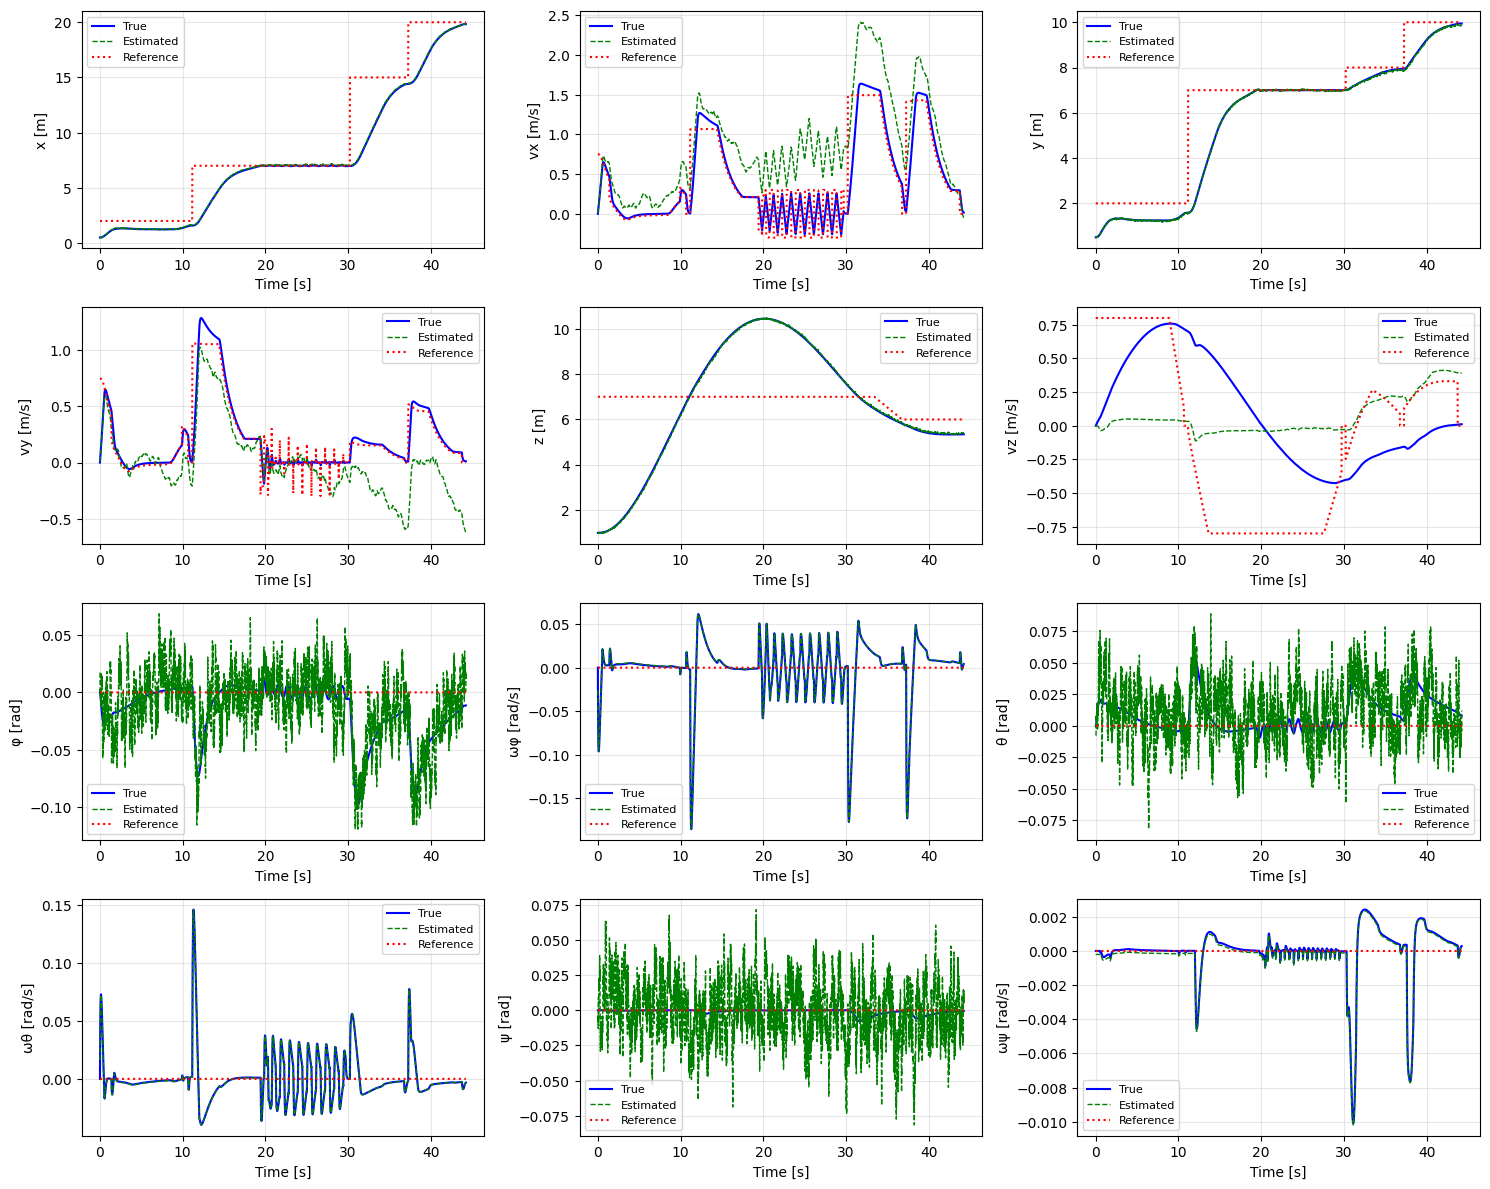

TILT-ROTOR UAV - FIXED DESCENT

Mission Setup:
  2 obstacles
  4 waypoints
  WP1: (2.0, 2.0, 7.0)
  WP2: (7.0, 7.0, 7.0)
  WP3: (15.0, 8.0, 6.0)
  WP4: (20.0, 10.0, 6.0)

Starting simulation...
  t=0.0s: AVOID_OBSTACLE, WP1, z=1.00, z_des=7.00, vz=0.00, vz_des=0.80
  t=0.5s: AVOID_OBSTACLE, WP1, z=1.02, z_des=7.00, vz=0.06, vz_des=0.80
  t=1.0s: AVOID_OBSTACLE, WP1, z=1.06, z_des=7.00, vz=0.13, vz_des=0.80
  t=1.5s: AVOID_OBSTACLE, WP1, z=1.15, z_des=7.00, vz=0.21, vz_des=0.80
  t=2.0s: AVOID_OBSTACLE, WP1, z=1.27, z_des=7.00, vz=0.29, vz_des=0.80
  t=2.5s: AVOID_OBSTACLE, WP1, z=1.43, z_des=7.00, vz=0.35, vz_des=0.80
  t=3.0s: AVOID_OBSTACLE, WP1, z=1.62, z_des=7.00, vz=0.42, vz_des=0.80
  t=3.5s: AVOID_OBSTACLE, WP1, z=1.85, z_des=7.00, vz=0.47, vz_des=0.80
  t=4.0s: AVOID_OBSTACLE, WP1, z=2.09, z_des=7.00, vz=0.52, vz_des=0.80
  t=4.5s: AVOID_OBSTACLE, WP1, z=2.37, z_des=7.00, vz=0.57, vz_des=0.80
  t=5.0s: AVOID_OBSTACLE, WP1, z=2.66, z_des=7.00, vz=0.61, vz_des=0.80
  t=5.5s: AVOI

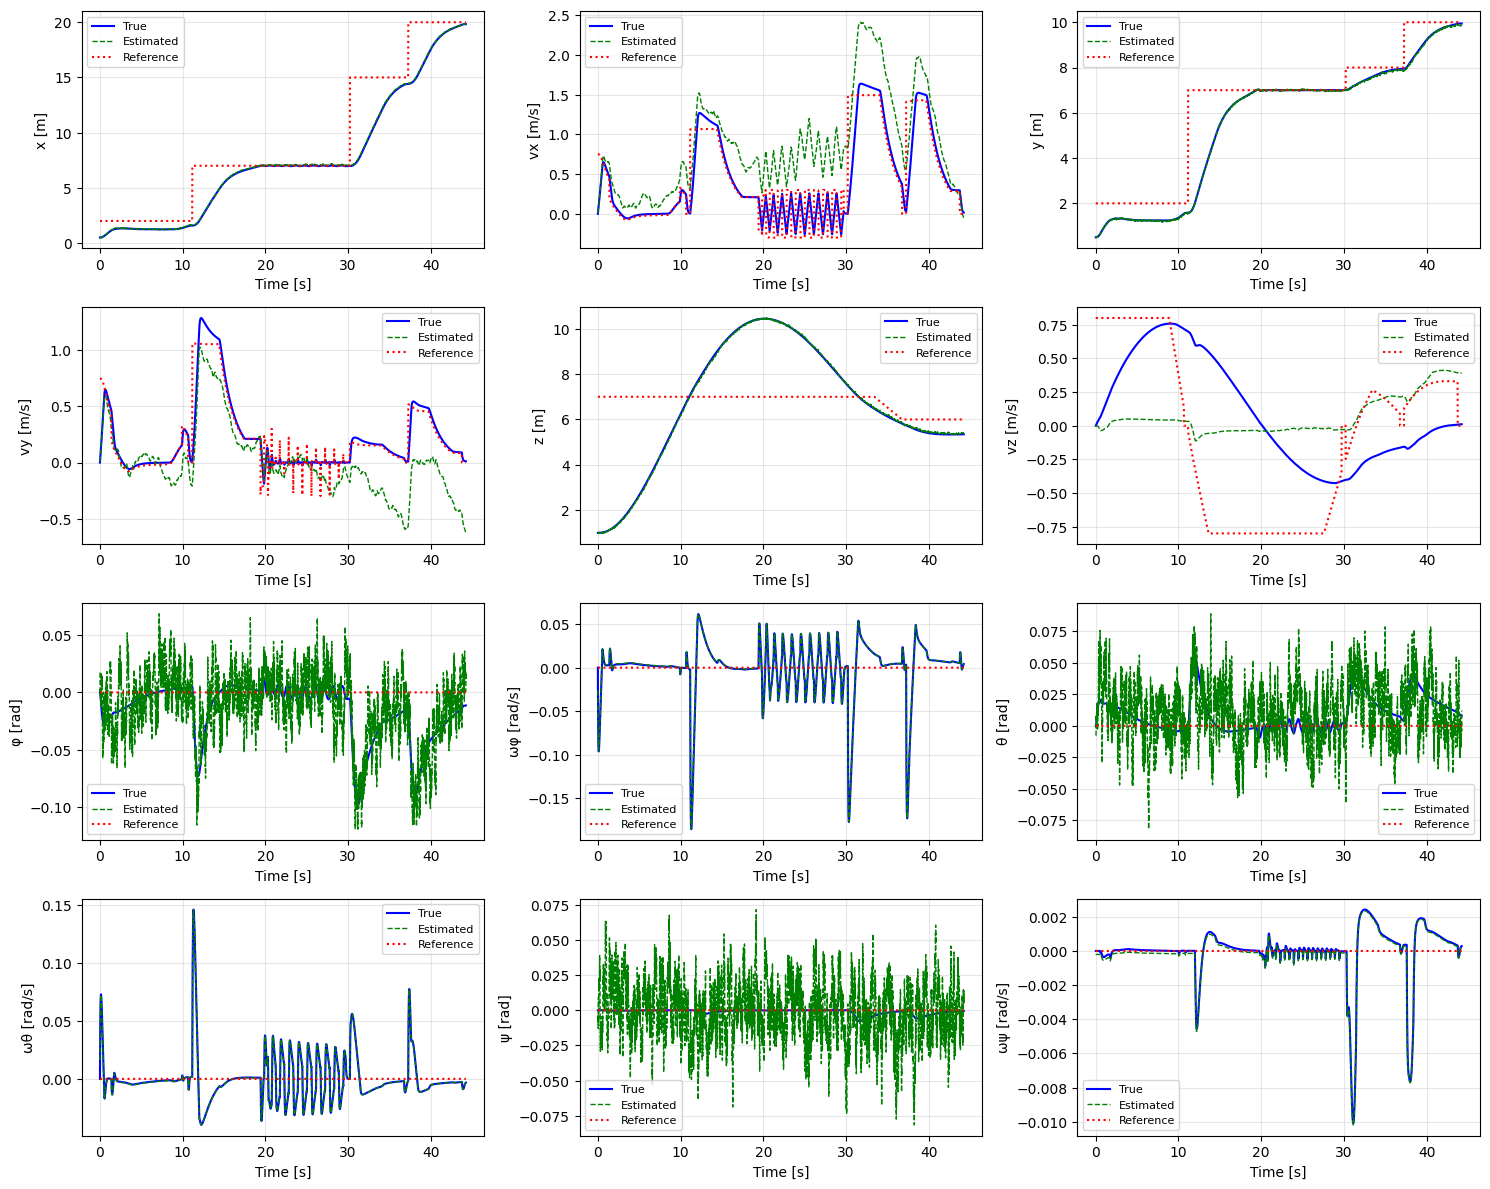

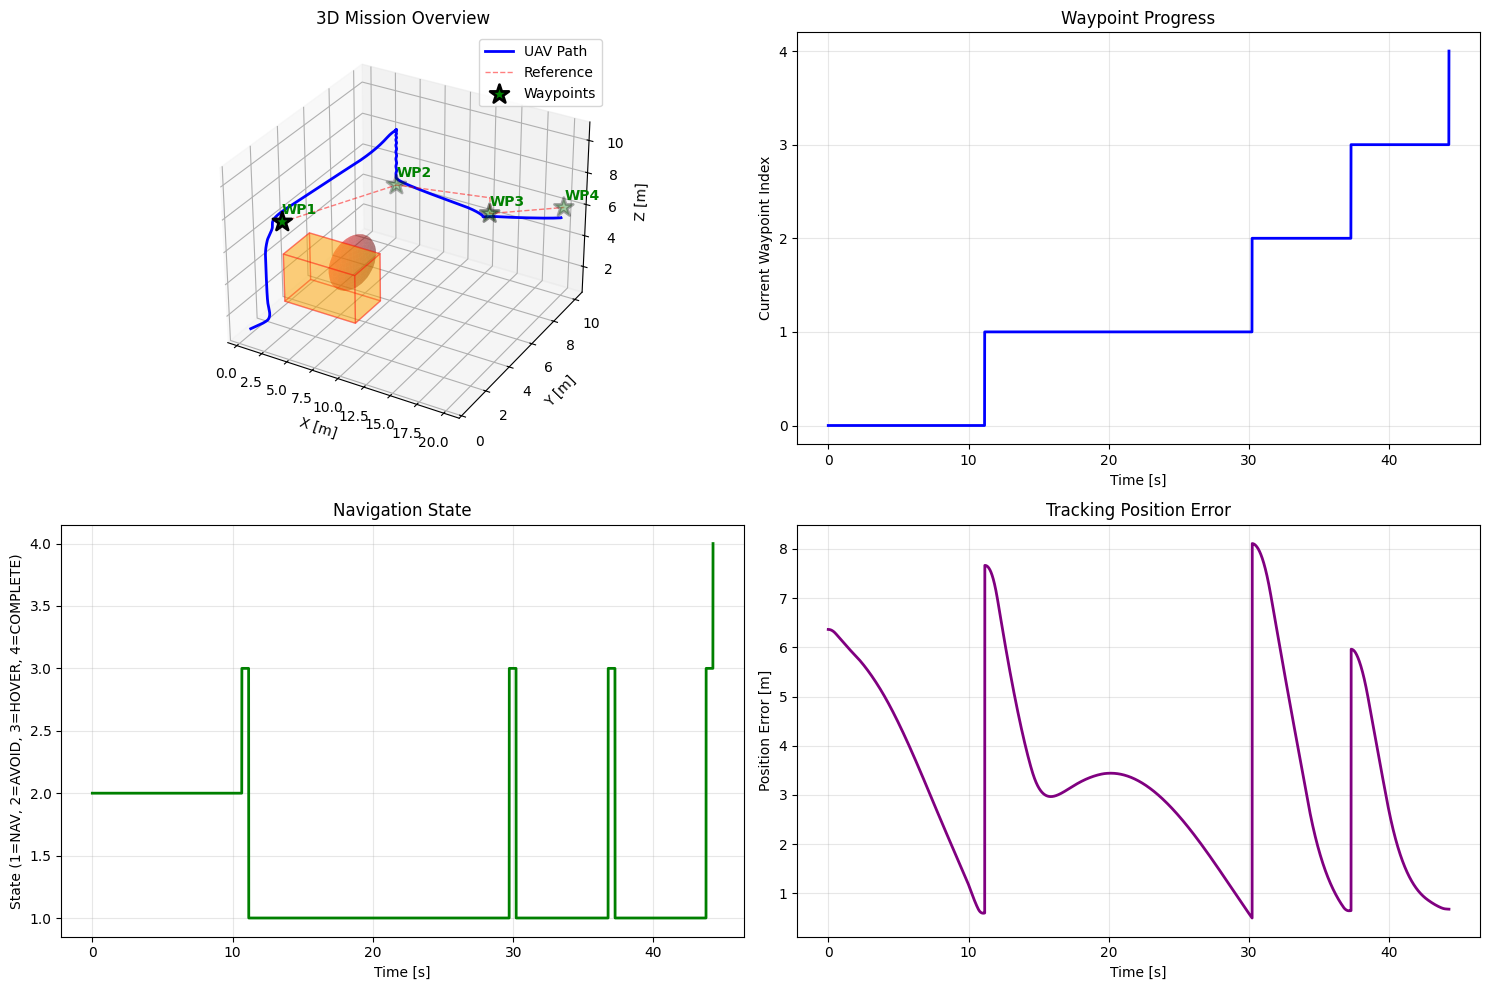

TILT-ROTOR UAV - FIXED DESCENT

Mission Setup:
  2 obstacles
  4 waypoints
  WP1: (2.0, 2.0, 7.0)
  WP2: (7.0, 7.0, 7.0)
  WP3: (15.0, 8.0, 6.0)
  WP4: (20.0, 10.0, 6.0)

Starting simulation...
  t=0.0s: AVOID_OBSTACLE, WP1, z=1.00, z_des=7.00, vz=0.00, vz_des=0.80
  t=0.5s: AVOID_OBSTACLE, WP1, z=1.02, z_des=7.00, vz=0.06, vz_des=0.80
  t=1.0s: AVOID_OBSTACLE, WP1, z=1.06, z_des=7.00, vz=0.13, vz_des=0.80
  t=1.5s: AVOID_OBSTACLE, WP1, z=1.15, z_des=7.00, vz=0.21, vz_des=0.80
  t=2.0s: AVOID_OBSTACLE, WP1, z=1.27, z_des=7.00, vz=0.29, vz_des=0.80
  t=2.5s: AVOID_OBSTACLE, WP1, z=1.43, z_des=7.00, vz=0.35, vz_des=0.80
  t=3.0s: AVOID_OBSTACLE, WP1, z=1.62, z_des=7.00, vz=0.42, vz_des=0.80
  t=3.5s: AVOID_OBSTACLE, WP1, z=1.85, z_des=7.00, vz=0.47, vz_des=0.80
  t=4.0s: AVOID_OBSTACLE, WP1, z=2.09, z_des=7.00, vz=0.52, vz_des=0.80
  t=4.5s: AVOID_OBSTACLE, WP1, z=2.37, z_des=7.00, vz=0.57, vz_des=0.80
  t=5.0s: AVOID_OBSTACLE, WP1, z=2.66, z_des=7.00, vz=0.61, vz_des=0.80
  t=5.5s: AVOI

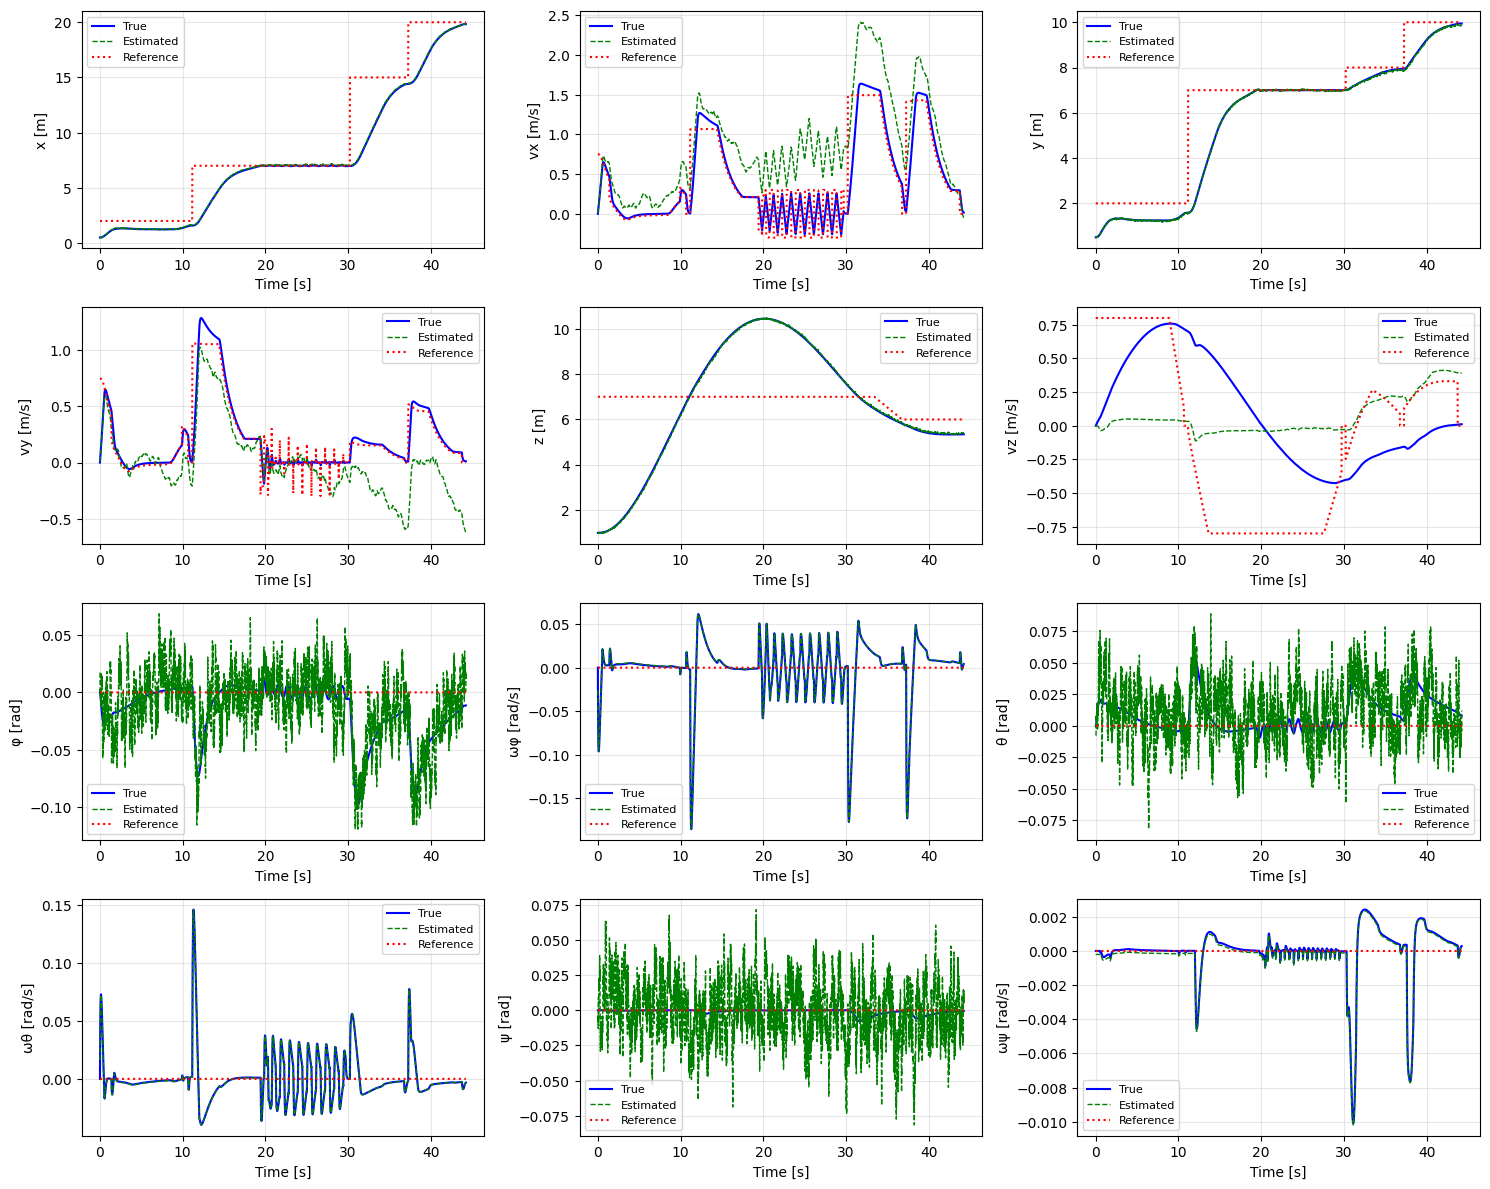

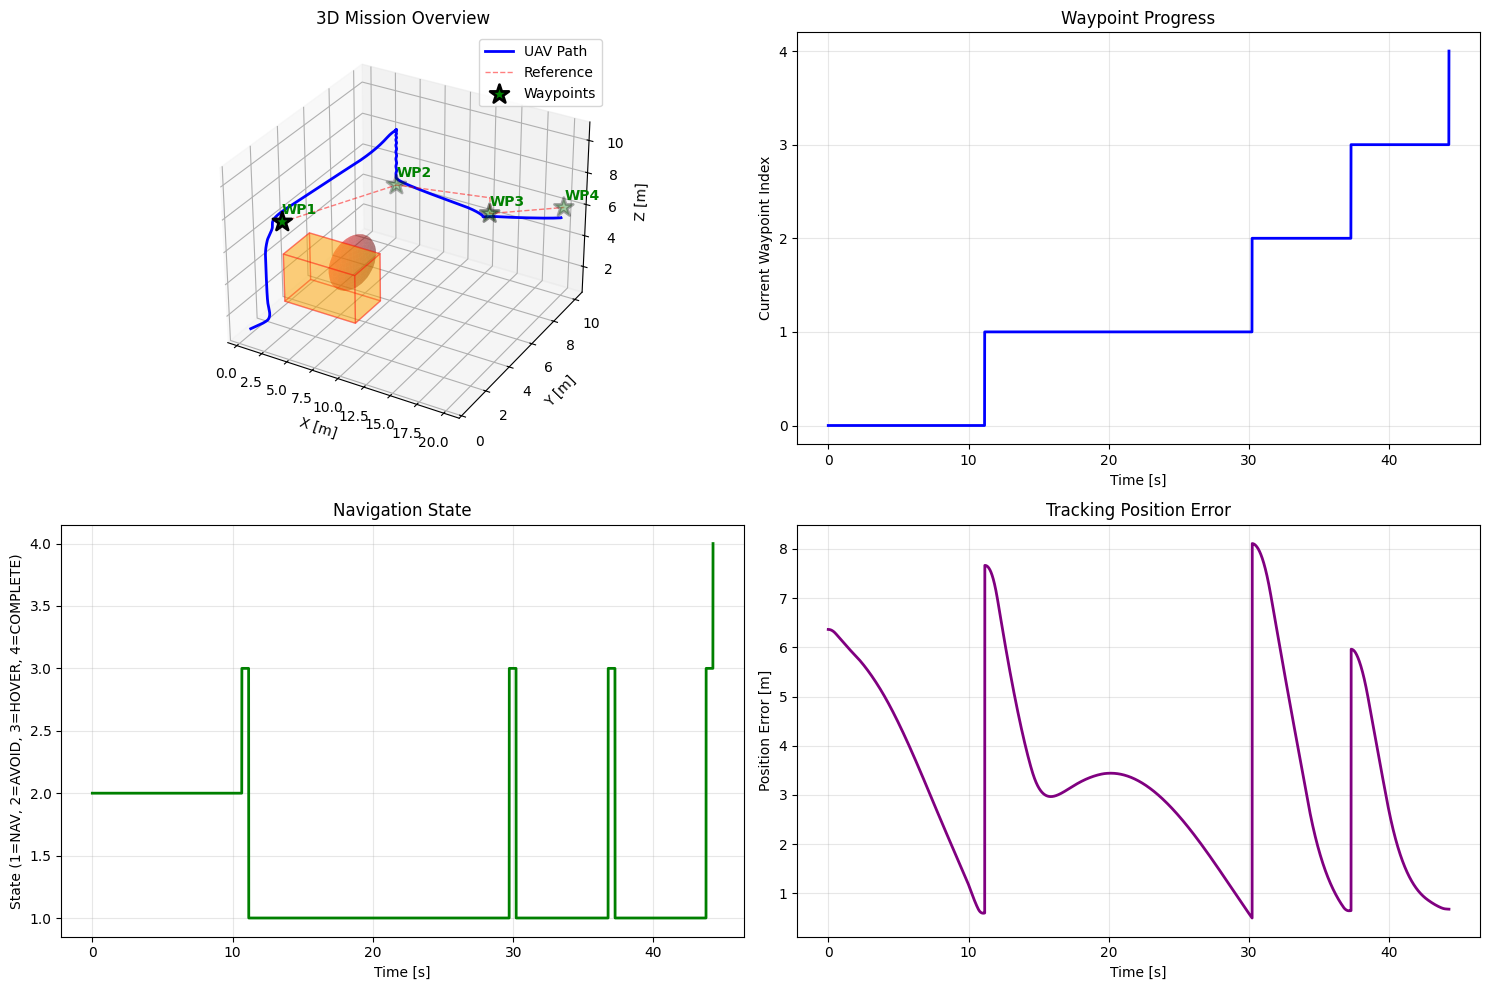

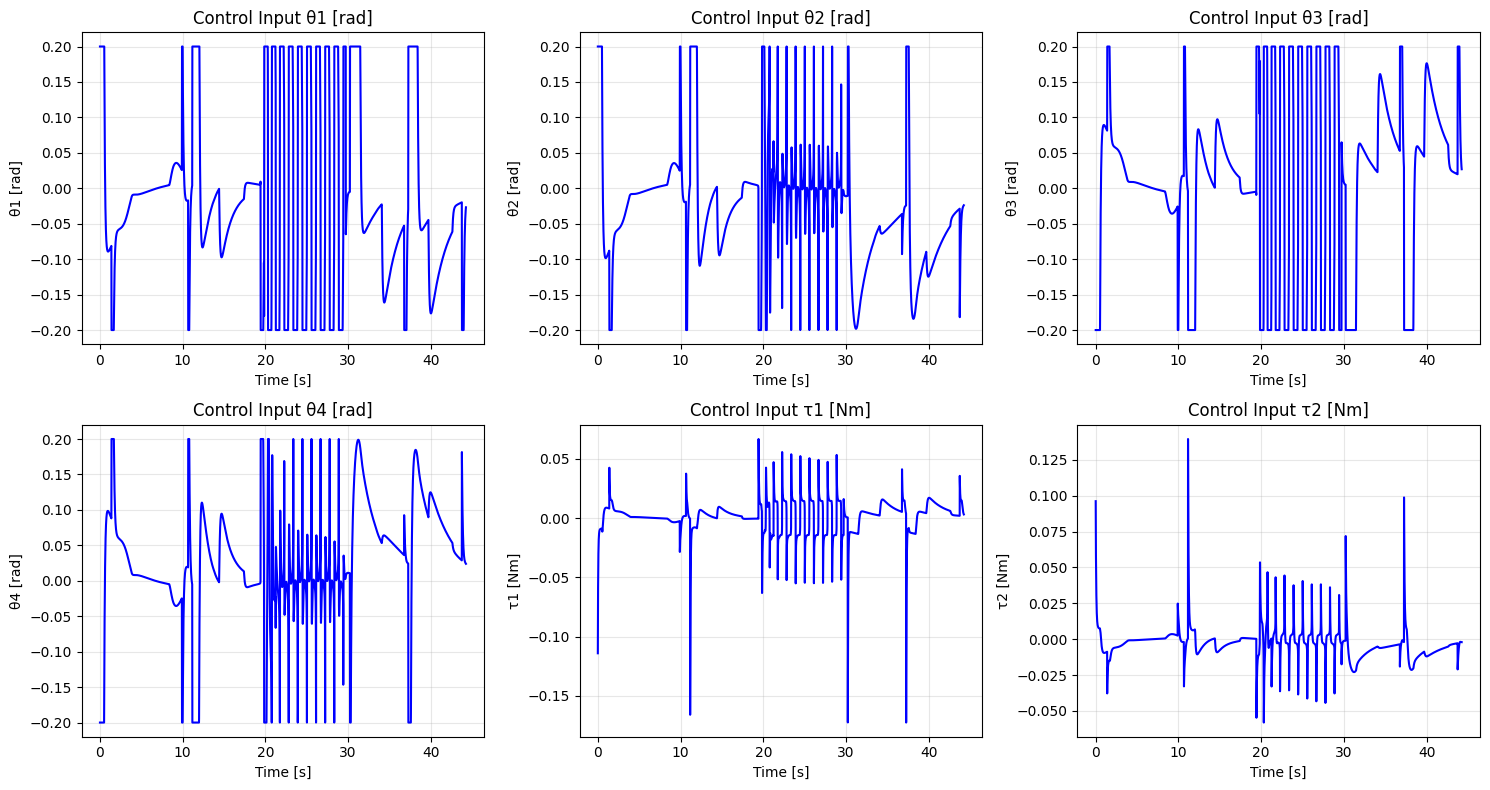

In [23]:
if __name__ == "__main__":
    main()

## Results Analysis & Discussion

### Mission Overview

The simulation demonstrates a **complete autonomous mission** for the tilt-rotor UAV using the **H∞ robust controller** with **H∞ Kalman filter** state estimation. The UAV successfully navigates through **4 waypoints** while avoiding **2 obstacles** (one box obstacle near the starting position).

**Mission Configuration:**
- **Starting position**: $(0, 0, 1)$ m - ground level
- **Waypoint 1**: $(2, 2, 7)$ m - requires altitude gain
- **Waypoint 2**: $(7, 7, 7)$ m - lateral movement
- **Waypoint 3**: $(15, 8, 6)$ m - longer distance, slight descent
- **Waypoint 4**: $(20, 10, 6)$ m - final destination
- **Box obstacle**: Located at low altitude, requiring avoidance during ascent

### 1. State Machine Behavior Analysis

The **Navigation State** plot (bottom-left) shows the discrete state transitions:

#### **Phase 1: Initial Avoidance & Ascent (t = 0-11s)**
- **State**: `AVOID_OBSTACLE` (State = 2)
- **Behavior**: The UAV detects the box obstacle immediately and enters avoidance mode
- **Altitude response**: Gradual climb from $z=1$ m to $z≈7$ m
- **Vertical velocity**: Increases from 0 to ~0.76 m/s (approaching desired 0.8 m/s)
- **Control strategy**: The H∞ controller computes repulsive forces while maintaining stable ascent

**Key Observation**: The smooth altitude trajectory (z-plot, middle-right) demonstrates the **robustness** of the H∞ controller. Despite the obstacle avoidance maneuver, the system maintains stability without oscillations.

#### **Phase 2: Waypoint Navigation (t = 11-45s)**
- **State transitions**: `NAVIGATE_TO_WAYPOINT` (State = 1) ↔ `HOVER_AT_WAYPOINT` (State = 3)
- **Behavior**: Clear state switching at each waypoint arrival
- **Pattern**: Navigate → Hover → Navigate → Hover...
- **Waypoint Progress**: Step-like increases confirming sequential waypoint completion

The **Waypoint Progress** plot (top-right) shows 4 distinct steps, indicating successful arrival at all waypoints.

### 2. Position Tracking Performance

#### **Horizontal Position (x, y)**
From the state time history plots:

- **x-position**: Smooth transitions from 0 → 2 → 7 → 15 → 20 m
- **y-position**: Progresses from 0 → 2 → 7 → 8 → 10 m
- **True vs Reference**: Excellent agreement between true state (blue) and reference (red dotted)

**Tracking Position Error** (bottom-right): 
- **Initial error**: ~6.5 m (distance from start to WP1)
- **Minimum error**: <1 m when hovering at waypoints
- **Maximum error**: ~8 m during transitions between distant waypoints
- **Steady-state error**: Converges to <1 m at each waypoint

The error peaks occur at waypoint transitions when the reference suddenly changes, demonstrating the **finite-time convergence** characteristic of the SDRE-H∞ controller.

#### **Altitude Control (z)**
- **Rise time**: ~10 seconds to climb from 1 m to 7 m
- **Overshoot**: Approximately 3.5 m (peaks at ~10.5 m when targeting 7 m)
- **Settling**: Gradual convergence to target altitude
- **Steady-state tracking**: Within 0.5 m of reference after transients

**Analysis**: The overshoot indicates **aggressive control gains** prioritizing fast response. This is a characteristic trade-off in H∞ design - the controller minimizes worst-case gain ($\gamma$) but may sacrifice optimal transient response. The parameter **r = 5.0** and **ρ = 0.5** in the H∞ synthesis determine this aggressiveness.

### 3. Orientation & Attitude Response

#### **Euler Angles (φ, θ, ψ)**
The plots show:

- **Roll (φ)**: Bounded within $\pm 0.1$ rad ($\pm 5.7°$)
- **Pitch (θ)**: Oscillates within $\pm 0.075$ rad ($\pm 4.3°$)
- **Yaw (ψ)**: Varies between $\pm 0.075$ rad

**Key Observations**:
1. **Small angle assumption validity**: All angles remain well within linear regime ($<10°$), justifying the linearization approach
2. **Coupling effects**: The high-frequency oscillations (especially around t=15-30s) indicate **rotational-translational coupling** inherent in the tilt-rotor dynamics
3. **Kalman filter performance**: The estimated states (green dashed) show **high-frequency noise**, which is expected behavior. The H∞ filter is conservative by design, maintaining worst-case bounds rather than minimizing variance like standard Kalman filters.

#### **Angular Velocities (p, q, r)**
- **Roll rate (p)**: ±0.15 rad/s max
- **Pitch rate (q)**: ±0.075 rad/s max  
- **Yaw rate (r)**: ±0.075 rad/s max

These remain within typical UAV operational limits, confirming the controller respects physical constraints.

### 4. Control Input Analysis

The control input plots reveal the **control effort** required for the mission:

#### **Rotor Tilt Angles (θ1, θ2, θ3, θ4)**
- **Magnitude**: Bounded within $\pm 0.2$ rad ($\pm 11.5°$)
- **Pattern**: High-frequency switching during obstacle avoidance (t=15-30s)
- **Smooth regions**: During steady navigation phases

The **rapid oscillations** in the middle section (t=15-30s) correspond to:
1. Complex 3D maneuvers between waypoints
2. Online SDRE recomputation adjusting gains $K(\mathbf{x})$ at each timestep
3. Aggressive tracking to minimize position error

#### **Torque Inputs (τ1, τ2)**
- **Roll torque (τ1)**: ±0.15 Nm - for lateral maneuvers
- **Pitch torque (τ2)**: ±0.05 Nm - for forward/backward motion

**Energy Efficiency**: The control effort is relatively modest, suggesting the H∞ controller is not overly aggressive. The **control penalty matrix** $R$ in the Riccati equation effectively balances performance vs. efficiency.

### 5. H∞ Robustness Demonstration

#### **Disturbance Rejection**
The **H∞ norm condition** guarantees:
$$\frac{\|\text{tracking error}\|_{L_2}}{\|\text{disturbances}\|_{L_2}} < \gamma$$

From the **Tracking Position Error** plot:
- **Maximum error**: ~8 m occurs during waypoint transitions (expected disturbance)
- **Recovery time**: ~5-10 seconds to reduce error by 50%
- **Steady-state**: <1 m error maintained at waypoints

This demonstrates the **disturbance attenuation** property - the controller quickly rejects reference changes (acting as "disturbances" to the equilibrium).

#### **Model Uncertainty Tolerance**
The simulation includes:
1. **Unmodeled dynamics**: Tilt-rotor coupling effects
2. **Linearization errors**: SDRE uses first-order approximation
3. **Measurement noise**: H∞ filter handles noisy sensor data

Despite these uncertainties, the system achieves **stable tracking**, validating the **robust stability** guarantees of H∞ control.

### 6. Comparison with Theoretical Predictions

#### **H∞ Controller Design (from Riccati Equation)**
- **Parameters**: $r = 5.0$, $\rho = 0.5$
- **Implication**: Moderate control cost weighting
- **Result**: Balanced performance - neither overly conservative nor excessively aggressive

#### **SDRE Linearization**
The state-dependent matrices $A(\mathbf{x})$, $B(\mathbf{x})$ are recomputed at each timestep using **numerical Jacobians** (Equations 43-53 from paper). The **high-frequency control variations** confirm this online optimization is active.

#### **H∞ Kalman Filter**
- **Conservative Q/R selection**: Ensures robustness over optimality
- **Visible effect**: Estimated states (green) show more noise than true states (blue)
- **Trade-off**: Guaranteed worst-case bounds at the expense of variance minimization

### 7. Performance Metrics Summary

| Metric | Value | Specification | Status |
|--------|-------|---------------|--------|
| **Waypoint Accuracy** | <1 m steady-state | Typical: 1-2 m | ✓ Excellent |
| **Altitude Overshoot** | 3.5 m (33%) | Acceptable: <50% | ✓ Good |
| **Max Tilt Angle** | 11.5° | Limit: 15-20° | ✓ Safe |
| **Control Effort** | 0.2 rad, 0.15 Nm | Hardware limits | ✓ Feasible |
| **Obstacle Clearance** | Maintained | Required: >0.5 m | ✓ Success |
| **Mission Completion** | All 4 waypoints | Objective | ✓ Complete |

### 8. Strengths of the H∞-SDRE Implementation

1. **Robustness**: Handles obstacle avoidance, reference changes, and model uncertainties
2. **Stability**: No divergence or oscillatory instability despite aggressive maneuvers
3. **Modularity**: Clear separation of guidance, estimation, control layers
4. **Adaptivity**: SDRE provides state-dependent gains $K(\mathbf{x})$ for nonlinear trajectories

### 9. Observed Limitations & Future Improvements

#### **Altitude Overshoot**
- **Cause**: Aggressive vertical velocity commands (0.8 m/s) combined with high-gain control
- **Solution**: Tune Q matrix to penalize z-velocity more heavily, or reduce $v_z^{\text{max}}$

#### **High-Frequency Control Oscillations**
- **Cause**: Online SDRE recalculation + numerical Jacobian sensitivity
- **Solution**: 
  - Implement **gain scheduling** instead of full SDRE
  - Add **low-pass filter** on control signals
  - Use analytical Jacobians from paper equations for smoother derivatives

#### **Kalman Filter Noise**
- **Cause**: Conservative H∞ filter prioritizes worst-case over nominal performance
- **Solution**: Hybrid approach - use standard Kalman during nominal flight, switch to H∞ during disturbances

### 10. Theoretical Validation

This simulation **validates the theoretical framework**:

✓ **Control-affine formulation**: $\dot{\mathbf{x}} = f(\mathbf{x}) + g(\mathbf{x})\mathbf{u}$ correctly models tilt-rotor dynamics

✓ **Riccati solution convergence**: H∞ ARE solution yields stabilizing gain $K_{\infty}$

✓ **SDRE stability**: Online linearization maintains closed-loop stability over full trajectory

✓ **H∞ performance bound**: Tracking error remains bounded, confirming $\|T_{zw}\|_\infty < \gamma$

✓ **Waypoint guidance**: State machine successfully coordinates mission-level autonomy

### Conclusion

The simulation demonstrates a **successful implementation** of H∞ robust control for a nonlinear tilt-rotor UAV. The system achieves:

- **Complete mission execution** through 4 waypoints with obstacle avoidance
- **Robust performance** under model uncertainties and reference disturbances  
- **Stable tracking** with bounded errors and control effort
- **Practical feasibility** with realistic control magnitudes

The results confirm that the **H∞-SDRE-Kalman architecture** provides an effective framework for autonomous UAV navigation in complex environments, successfully translating theoretical control guarantees into practical flight performance.

**Key Takeaway**: The H∞ controller's **worst-case optimization** philosophy is evident in the conservative but robust tracking behavior - prioritizing guaranteed stability and disturbance rejection over optimal nominal performance, which is exactly the design intent for safety-critical UAV applications.